In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from datetime import datetime
import sys
import argparse
from pathlib import Path

In [6]:
from june.geography import Geography
from june.demography.demography import (
    load_age_and_sex_generators_for_bins,
    Demography,
    Population,
    load_comorbidity_data,
    generate_comorbidity,
)
from june.paths import data_path, configs_path
from june.epidemiology.epidemiology import Epidemiology
from june.epidemiology.infection import Infection, HealthIndexGenerator, InfectionSelector, InfectionSelectors
from june.epidemiology.infection_seed import InfectionSeed, InfectionSeeds
from june.interaction import Interaction
from june.groups import Hospital, Hospitals, Cemeteries
from june.distributors import HospitalDistributor
from june.hdf5_savers import generate_world_from_hdf5
from june.policy import Policy, Policies
from june.records import Record
from june.simulator import Simulator
from june.records import Record, RecordReader

from camps.activity import CampActivityManager
from camps.paths import camp_data_path, camp_configs_path
from camps.world import World
from camps.groups.leisure import generate_leisure_for_world, generate_leisure_for_config
from camps.camp_creation import (
    generate_empty_world,
    populate_world,
    distribute_people_to_households,
)  # this is loaded from the ../camp_scripts folder


2021-10-28 11:07:15,109 - camps.paths - WARNING - No --camp_data argument given - defaulting to:
/Users/josephbullock/Documents/campmodelling/UNGP-settlement-modelling-private/camp_data
2021-10-28 11:07:15,110 - camps.paths - WARNING - No --configs_camps argument given - defaulting to:
/Users/josephbullock/Documents/campmodelling/UNGP-settlement-modelling-private/configs_camps


In [7]:
from camps.groups import PumpLatrines, PumpLatrineDistributor
from camps.groups import DistributionCenters, DistributionCenterDistributor
from camps.groups import Communals, CommunalDistributor
from camps.groups import FemaleCommunals, FemaleCommunalDistributor
from camps.groups import Religiouss, ReligiousDistributor
from camps.groups import Shelter, Shelters, ShelterDistributor
from camps.groups import IsolationUnit, IsolationUnits
from camps.groups import LearningCenters
from camps.distributors import LearningCenterDistributor
from camps.groups import PlayGroups, PlayGroupDistributor
from camps.groups import EVouchers, EVoucherDistributor
from camps.groups import NFDistributionCenters, NFDistributionCenterDistributor
from camps.groups import SheltersVisitsDistributor

## Initialize the world

When we create the camp to be simulated, we call this the 'world'. The world is initialised after specifying which geographical regions you want to simulate. We can do this by using the `filter_key` argument in the `generate_empty_world` function. Cox's Bazar Expansion Site is made up of camps (which we call regions), UNHCR blocks (which we call super areas) and Mahjee blocks (which we call areas). These are the 3 heirarchical levels on which our model works. You can pass lists of the regions/super_areas/areas to the function here. Alternatively, by leaving the function empty you can generate the entire Cox's Bazar Expansion Site consisting of 112 super areas.

In [8]:
# create empty world's geography
world = generate_empty_world(filter_key = {"region" : ["CXB-219"]})

2021-10-28 11:07:19,760 - june.geography.geography - INFO - There are 65 areas and 4 super_areas and 1 regions in the world.


In [9]:
# populate empty world
populate_world(world)

In [10]:
# distribute people to households
distribute_people_to_households(world)

In [11]:
# distirbute hospitals
hospitals = Hospitals.from_file(
    filename=camp_data_path / "input/hospitals/hospitals.csv"
)
for hospital in hospitals:
    hospital.area = world.areas.get_closest_area(hospital.coordinates)
world.hospitals = hospitals
hospital_distributor = HospitalDistributor(
    hospitals, medic_min_age=20, patients_per_medic=10
)
hospital_distributor.assign_closest_hospitals_to_super_areas(
    world.super_areas
)
hospital_distributor.distribute_medics_from_world(world.people)

2021-10-28 11:07:21,712 - hospitals - INFO - There are 8 hospitals in the world.


In [12]:
world.pump_latrines = PumpLatrines.for_areas(world.areas)
world.play_groups = PlayGroups.for_areas(world.areas)
world.distribution_centers = DistributionCenters.for_areas(world.areas)
world.communals = Communals.for_areas(world.areas)
world.female_communals = FemaleCommunals.for_areas(world.areas)
world.religiouss = Religiouss.for_areas(world.areas)
world.e_vouchers = EVouchers.for_areas(world.areas)
world.n_f_distribution_centers = NFDistributionCenters.for_areas(world.areas)

2021-10-28 11:07:22,405 - social_venue - INFO - Domain 0 has 225 pump_latrines(s)
2021-10-28 11:07:22,426 - social_venue - INFO - Domain 0 has 505 play_groups(s)
2021-10-28 11:07:22,433 - social_venue - INFO - Domain 0 has 7 distribution_centers(s)
2021-10-28 11:07:22,469 - social_venue - INFO - Domain 0 has 125 communals(s)
2021-10-28 11:07:22,490 - social_venue - INFO - Domain 0 has 67 female_communals(s)
2021-10-28 11:07:22,943 - social_venue - INFO - Domain 0 has 2064 religiouss(s)
2021-10-28 11:07:22,951 - social_venue - INFO - Domain 0 has 7 e_vouchers(s)
2021-10-28 11:07:22,964 - social_venue - INFO - Domain 0 has 36 n_f_distribution_centers(s)


In [13]:
world.cemeteries = Cemeteries()

## Geography exploration

The geography is initialised first and can be explored.

### UNHCR camp blocks inside the World

In [14]:
super_areas = []
for super_area in world.super_areas:
    super_areas.append(super_area.name)

In [15]:
super_areas[:5]

['CXB-219-A', 'CXB-219-B', 'CXB-219-C', 'CXB-219-D']

### Mahjee blocks inside World

In [16]:
areas = []
for area in world.areas:
    areas.append(area.name)

In [17]:
areas[:5]

['CXB-219-001', 'CXB-219-002', 'CXB-219-003', 'CXB-219-004', 'CXB-219-005']

## Demography exploration

Once we have populated the 'digital twin' we can explore some of the attributes of the people we have created in the simulation.

### UNHCR block residents

In [18]:
sample_ages = []
sample_sexes = []
for person in world.super_areas.members[0].people:
    sample_ages.append(person.age)
    sample_sexes.append(person.sex)

In [19]:
sample_sexes[:5], sample_ages[:5]

(['f', 'm', 'm', 'f', 'f'], [50, 35, 52, 33, 63])

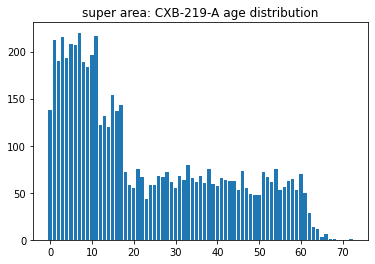

In [20]:
ages, counts = np.unique(sample_ages, return_counts=True)
plt.bar(ages, counts)
plt.title('super area: {} age distribution'.format(world.super_areas.members[0].name))
plt.show()

In [21]:
print ('The % children between ages 0-16 is {}%'.format(round(np.sum(counts[:16])/(np.sum(counts[:16])+np.sum(counts[16:]))*100)))

The % children between ages 0-16 is 49%


## Households

In this model, we will use the term 'family' and 'household' interchangeably. After populating the 'digital twin', we need to cluster people into families. To do this, we take account of age structure so that children live with adults, that there are some intergenerational households and such that we might also have some households of only adults.

### Household size distribution

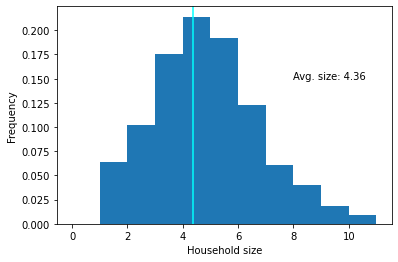

In [22]:
household_sizes = [household.size for household in world.households]
plt.hist(household_sizes, density=True, bins=np.arange(0,12))
plt.xlabel("Household size")
plt.ylabel("Frequency")
plt.axvline(np.mean(household_sizes), color="cyan")
plt.text(8, 0.150, f"Avg. size: {(np.mean(household_sizes)):.2f}")
plt.show()

# Shelters

Shelters house people in the camp. Since we know that families (houseohlds) often share shelters with other families, we can set the `sharing_shelter_ratio` to cluster families into shared shelters.

In [23]:
world.shelters = Shelters.for_areas(world.areas)
shelter_distributor = ShelterDistributor(sharing_shelter_ratio = 0.75) # proportion of families that share a shelter
for area in world.areas:
    shelter_distributor.distribute_people_in_shelters(area.shelters, area.households)

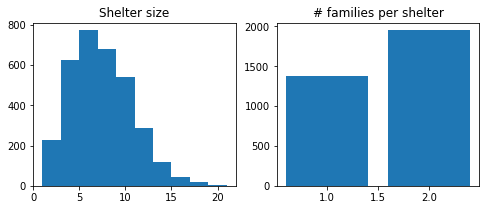

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))
shelter_sizes = [shelter.size for shelter in world.shelters]
shelter_families = [shelter.n_families for shelter in world.shelters]
ax[0].hist(shelter_sizes)
ax[0].set_title("Shelter size")
shelter_families = {1 : len([shelter for shelter in world.shelters if shelter.n_families == 1]),
                    2 : len([shelter for shelter in world.shelters if shelter.n_families == 2])}
ax[1].bar(shelter_families.keys(), shelter_families.values())
ax[1].set_title("# families per shelter")
plt.show()

## Activity exploration

Once different activity locations are seeded in the 'digital twin' we can explore how many there are in different areas of the twin, and their coordinates to check they've all been added correctly.

### Pumps and latrines 

In [25]:
pumps_and_latrines = []
for pump_latrine in world.areas.members[0].pump_latrines:
    pumps_and_latrines.append(pump_latrine)

In [26]:
print ('There are {} pumps and latrines in area {}'.format(len(pumps_and_latrines), world.areas.members[0].name))

There are 4 pumps and latrines in area CXB-219-001


### Distribution centers

In [27]:
distribution_centers = []
for center in world.distribution_centers:
    distribution_centers.append(center)

In [28]:
distribution_centers[0].coordinates

array([21.21176333, 92.13597667])

### Non-food Distribution centers

In [29]:
non_food_distribution_centers = []
for center in world.n_f_distribution_centers:
    non_food_distribution_centers.append(center)

In [30]:
non_food_distribution_centers[0].coordinates

array([21.1962 , 92.14936])

### E-Voucher outlets

In [31]:
e_voucher_outlets = []
for center in world.e_vouchers:
    e_voucher_outlets.append(center)

In [32]:
e_voucher_outlets[0].coordinates

array([21.21176333, 92.13597667])

### Communal spaces

In [33]:
communal_spaces = []
for space in world.communals:
    communal_spaces.append(space)

In [34]:
communal_spaces[0].coordinates

array([21.19621, 92.14924])

### Female friendly communal spaces

In [35]:
female_communal_spaces = []
for space in world.female_communals:
    female_communal_spaces.append(space)

In [36]:
female_communal_spaces[0].coordinates

array([21.19588, 92.152  ])

### Religious sites

In [37]:
religious = []
for rel in world.religiouss:
    religious.append(rel)

In [38]:
religious[0].coordinates

array([21.20069, 92.15216])

# Adding the infection

The selector handles how infections are handled in the code. You can set different 'symptom trajectories' (e.g. exposed->mild->severe->hospitalised->intensive care) from different files. Here, we use the default.

In [39]:
selector = InfectionSelector.from_file()

In [56]:
selectors = InfectionSelectors([selector])

# Adding the interaction

The interaction class handles how many contacts people have in different locations and with who. If contact matrices are available, these can be coded in a `.yaml` file and fed into the class here.

In [41]:
interaction = Interaction.from_file(
    config_filename=camp_configs_path / "defaults/interaction/" / "ContactInteraction_med_low_low_low.yaml",
)

# Set policies

Policies control how 'operational interventions' are set in the camp. Here we set some social distancing policies, policies relating to medical care, such as people with severe symptoms being hospitalised, and individual and activity policies which can dynamically change how often and where people go, e.g. here, we close all female communal spaces and non-food distirbution centers which the camp did back in March

In [46]:
policies = Policies.from_file(
        camp_configs_path / "defaults/policy/home_care_policy.yaml",
        base_policy_modules=("june.policy", "camps.policy"),
    )

In [47]:
policies.policies

# Seed the disease

Set intial seeding conditions. This can be done at the camp level specifically, or generally by seeding them randomly. Here the `n_cases` is the number of randomly seeded people over the entire population.

In [51]:
infection_seed = InfectionSeed.from_uniform_cases(
    world=world, infection_selector=selector, cases_per_capita=0.01, date="2020-03-01"
)

In [58]:
infection_seeds = InfectionSeeds([infection_seed])

In [59]:
epidemiology = Epidemiology(infection_selectors=selectors, infection_seeds=infection_seeds)

## Select config file

Before running the simualtion we must select the config file which defines how the world is set up and the simualtor will work. Specifically, the condif file specifies which activities will be included, how long we'll run the simualtion for, what the initial starting day will be and what the structure of weekdays and weekends will look like (if different)

In [52]:
CONFIG_PATH = "../configs_camps/config_demo.yaml"

# Initialise activities

The final step to intialising the simulator class which brings all of this together is to inialise all the activity distirbutors (the term 'leisure' is a legacy of the original version of this code used for modelling COVID-19 in the UK). This will mean that people know where they can go at and given time.

In [53]:
leisure = generate_leisure_for_config(world=world, config_filename=CONFIG_PATH)
leisure.leisure_distributors = {}
leisure.leisure_distributors["pump_latrine"] = PumpLatrineDistributor.from_config(
    world.pump_latrines
)
leisure.leisure_distributors["play_group"] = PlayGroupDistributor.from_config(
    world.play_groups
)
leisure.leisure_distributors[
    "distribution_center"
] = DistributionCenterDistributor.from_config(world.distribution_centers)
leisure.leisure_distributors["communal"] = CommunalDistributor.from_config(
    world.communals
)
leisure.leisure_distributors[
    "female_communals"
] = FemaleCommunalDistributor.from_config(world.female_communals)
leisure.leisure_distributors["religious"] = ReligiousDistributor.from_config(
    world.religiouss
)
leisure.leisure_distributors["e_voucher"] = EVoucherDistributor.from_config(
    world.e_vouchers
)
leisure.leisure_distributors[
    "n_f_distribution_center"
] = NFDistributionCenterDistributor.from_config(world.n_f_distribution_centers)
leisure.leisure_distributors[
    "shelters_visits"
] = SheltersVisitsDistributor.from_config()
leisure.leisure_distributors["shelters_visits"].link_shelters_to_shelters(
    world.super_areas
)
# associate social activities to shelters
leisure.distribute_social_venues_to_areas(world.areas, world.super_areas)

2021-10-28 11:30:54,585 - leisure - INFO - Linking households and care homes for visits
2021-10-28 11:30:54,586 - leisure - INFO - Done
2021-10-28 11:30:54,586 - leisure - INFO - Distributing social venues to areas
2021-10-28 11:30:54,587 - leisure - INFO - Distributed in 0 of 65 areas.
2021-10-28 11:30:54,666 - leisure - INFO - Distributed in 65 of 65 areas.


# Initialise simulator and run

The recorder is defined which will log all interactions and infections in the simualation for later analysis. The `record_path` can be changed to any path where you want the recorded data to be stored.

In [61]:
record = Record(
    record_path='results', 
    record_static_data=True
)


The simulator is defined with all the different necessary components we have built up so far

In [62]:
Simulator.ActivityManager = CampActivityManager
simulator = Simulator.from_file(
    world=world,
    interaction=interaction,
    leisure=leisure,
    policies=policies,
    config_filename=CONFIG_PATH,
    epidemiology=epidemiology,
    record=record,
)

Finally we can run a small simualation

In [63]:
%%time
simulator.run()

2021-10-28 11:36:33,901 - simulator - INFO - Starting simulation for 120 days at day 2020-05-24 00:00:00,to run for 120 days
2021-10-28 11:36:34,379 - rank - INFO - Next timestep
2021-10-28 11:36:34,380 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:36:34,557 - rank - INFO - Rank 0 -- move_people -- 0.1757108810002137
2021-10-28 11:36:34,557 - rank - INFO - Rank 0 -- move_people_waiting -- 3.513000137900235e-06
2021-10-28 11:36:34,558 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.424000058454112e-06,2.86102294921875e-06 - 2020-05-24 00:00:00
2021-10-28 11:36:34,562 - simulator - INFO - Info for rank 0, Date = 2020-05-24 00:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:36:34,605 - rank - INFO - Rank 0 -- interaction -- 0.04721545499978674
2021-10-28 11:36:34,610 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.004040746000100626,0.004040956497192383 - 2020-05-24 00:00:00
2021-10-28 11:36:34,638 - 

2021-10-28 11:36:38,190 - simulator - INFO - Info for rank 0, Date = 2020-05-25 02:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:36:38,240 - rank - INFO - Rank 0 -- interaction -- 0.05383061800012001
2021-10-28 11:36:38,241 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00019404699992264796,0.0001938343048095703 - 2020-05-25 02:00:00
2021-10-28 11:36:38,269 - rank - INFO - Rank 0 -- interaction_waiting -- 9.468999905948294e-06
2021-10-28 11:36:38,284 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014847327999859772,0.014848947525024414 - 2020-05-25 02:00:00

2021-10-28 11:36:38,286 - rank - INFO - Next timestep
2021-10-28 11:36:38,286 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:36:38,684 - rank - INFO - Rank 0 -- move_people -- 0.3970784169998751
2021-10-28 11:36:38,685 - rank - INFO - Rank 0 -- move_people_waiting -- 5.28800001120544e-06
2021-10-28 11:36:38,685 - activity_manager - INFO - CMS: People 

2021-10-28 11:36:41,469 - rank - INFO - Next timestep
2021-10-28 11:36:41,470 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:36:41,898 - rank - INFO - Rank 0 -- move_people -- 0.42762733600011416
2021-10-28 11:36:41,899 - rank - INFO - Rank 0 -- move_people_waiting -- 3.484000217213179e-06
2021-10-28 11:36:41,899 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.2059999739431078e-06,2.86102294921875e-06 - 2020-05-26 06:00:00
2021-10-28 11:36:41,904 - simulator - INFO - Info for rank 0, Date = 2020-05-26 06:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:36:41,962 - rank - INFO - Rank 0 -- interaction -- 0.06188578500018593
2021-10-28 11:36:41,963 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00026597200007927313,0.00026607513427734375 - 2020-05-26 06:00:00
2021-10-28 11:36:41,990 - rank - INFO - Rank 0 -- interaction_waiting -- 0.0002343049998216884
2021-10-28 11:36:42,003 - simulator - INFO - CMS: 

2021-10-28 11:36:45,157 - rank - INFO - Rank 0 -- interaction -- 0.06558306500005529
2021-10-28 11:36:45,158 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003699669998695754,0.00037026405334472656 - 2020-05-27 08:00:00
2021-10-28 11:36:45,187 - rank - INFO - Rank 0 -- interaction_waiting -- 9.44600014918251e-06
2021-10-28 11:36:45,202 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014293777000148111,0.01429605484008789 - 2020-05-27 08:00:00

2021-10-28 11:36:45,203 - rank - INFO - Next timestep
2021-10-28 11:36:45,204 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:36:45,386 - rank - INFO - Rank 0 -- move_people -- 0.1819841120000092
2021-10-28 11:36:45,387 - rank - INFO - Rank 0 -- move_people_waiting -- 4.953000143359532e-06
2021-10-28 11:36:45,387 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.2550001378695015e-06,2.86102294921875e-06 - 2020-05-27 10:00:00
2021-10-28 11:36:45,392 - simulator - INFO - Info f

2021-10-28 11:36:48,193 - rank - INFO - Rank 0 -- move_people -- 0.18366729699982898
2021-10-28 11:36:48,194 - rank - INFO - Rank 0 -- move_people_waiting -- 3.827000000455882e-06
2021-10-28 11:36:48,194 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.251999942222028e-06,3.0994415283203125e-06 - 2020-05-29 00:00:00
2021-10-28 11:36:48,198 - simulator - INFO - Info for rank 0, Date = 2020-05-29 00:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:36:48,240 - rank - INFO - Rank 0 -- interaction -- 0.04524168199986889
2021-10-28 11:36:48,241 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003122489999896061,0.00031185150146484375 - 2020-05-29 00:00:00
2021-10-28 11:36:48,267 - rank - INFO - Rank 0 -- interaction_waiting -- 0.00018035700009022548
2021-10-28 11:36:48,279 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012253918999931557,0.012253761291503906 - 2020-05-29 00:00:00

2021-10-28 11:36:48,281 - rank - INFO - Next timestep
2021-1

2021-10-28 11:36:51,330 - rank - INFO - Rank 0 -- interaction_waiting -- 9.708999868962565e-06
2021-10-28 11:36:51,343 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012975783000001684,0.012978076934814453 - 2020-05-30 03:00:00

2021-10-28 11:36:51,345 - rank - INFO - Next timestep
2021-10-28 11:36:51,345 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:36:51,748 - rank - INFO - Rank 0 -- move_people -- 0.40161453600012464
2021-10-28 11:36:51,748 - rank - INFO - Rank 0 -- move_people_waiting -- 6.977900011406746e-05
2021-10-28 11:36:51,749 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.6230000003124587e-06,2.86102294921875e-06 - 2020-05-30 05:00:00
2021-10-28 11:36:51,753 - simulator - INFO - Info for rank 0, Date = 2020-05-30 05:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:36:51,809 - rank - INFO - Rank 0 -- interaction -- 0.05979242199987311
2021-10-28 11:36:51,810 - epidemiology - INFO - CMS: Infection CO

2021-10-28 11:36:54,842 - simulator - INFO - Info for rank 0, Date = 2020-05-31 07:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:36:54,895 - rank - INFO - Rank 0 -- interaction -- 0.056795078000050125
2021-10-28 11:36:54,896 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002051280000614497,0.00020503997802734375 - 2020-05-31 07:00:00
2021-10-28 11:36:54,922 - rank - INFO - Rank 0 -- interaction_waiting -- 8.620000016890117e-06
2021-10-28 11:36:54,935 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012353522000012163,0.012354850769042969 - 2020-05-31 07:00:00

2021-10-28 11:36:54,936 - rank - INFO - Next timestep
2021-10-28 11:36:54,937 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:36:55,333 - rank - INFO - Rank 0 -- move_people -- 0.3964439050000692
2021-10-28 11:36:55,334 - rank - INFO - Rank 0 -- move_people_waiting -- 5.843300004926277e-05
2021-10-28 11:36:55,335 - activity_manager - INFO - CMS: Peopl

2021-10-28 11:36:57,977 - rank - INFO - Next timestep
2021-10-28 11:36:57,977 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:36:58,159 - rank - INFO - Rank 0 -- move_people -- 0.1813439490001656
2021-10-28 11:36:58,160 - rank - INFO - Rank 0 -- move_people_waiting -- 3.313999968668213e-06
2021-10-28 11:36:58,160 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.502999905118486e-06,1.9073486328125e-06 - 2020-06-01 10:00:00
2021-10-28 11:36:58,165 - simulator - INFO - Info for rank 0, Date = 2020-06-01 10:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:36:58,206 - rank - INFO - Rank 0 -- interaction -- 0.04545837099999517
2021-10-28 11:36:58,207 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002071180001621542,0.00020694732666015625 - 2020-06-01 10:00:00
2021-10-28 11:36:58,233 - rank - INFO - Rank 0 -- interaction_waiting -- 8.761999879425275e-06
2021-10-28 11:36:58,246 - simulator - INFO - CMS: Time

2021-10-28 11:37:01,034 - rank - INFO - Rank 0 -- interaction -- 0.04655596600014178
2021-10-28 11:37:01,036 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0006519789999401837,0.0006518363952636719 - 2020-06-03 00:00:00
2021-10-28 11:37:01,062 - rank - INFO - Rank 0 -- interaction_waiting -- 9.959999943021103e-06
2021-10-28 11:37:01,077 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014809455999966303,0.014811038970947266 - 2020-06-03 00:00:00

2021-10-28 11:37:01,079 - rank - INFO - Next timestep
2021-10-28 11:37:01,080 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:37:01,503 - rank - INFO - Rank 0 -- move_people -- 0.42298016699987784
2021-10-28 11:37:01,504 - rank - INFO - Rank 0 -- move_people_waiting -- 5.050000027040369e-06
2021-10-28 11:37:01,505 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.1240000478428556e-06,1.9073486328125e-06 - 2020-06-03 02:00:00
2021-10-28 11:37:01,509 - simulator - INFO - Info 

2021-10-28 11:37:04,579 - rank - INFO - Rank 0 -- move_people -- 0.4072937620001085
2021-10-28 11:37:04,579 - rank - INFO - Rank 0 -- move_people_waiting -- 5.774400005975622e-05
2021-10-28 11:37:04,580 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.871999868148123e-06,1.9073486328125e-06 - 2020-06-04 04:00:00
2021-10-28 11:37:04,584 - simulator - INFO - Info for rank 0, Date = 2020-06-04 04:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:37:04,639 - rank - INFO - Rank 0 -- interaction -- 0.0585848809998879
2021-10-28 11:37:04,640 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00044258099978833343,0.0004420280456542969 - 2020-06-04 04:00:00
2021-10-28 11:37:04,670 - rank - INFO - Rank 0 -- interaction_waiting -- 9.481000006417162e-06
2021-10-28 11:37:04,683 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013485277999961909,0.013486862182617188 - 2020-06-04 04:00:00

2021-10-28 11:37:04,685 - rank - INFO - Next timestep
2021-10-28 1

2021-10-28 11:37:08,137 - rank - INFO - Rank 0 -- interaction_waiting -- 0.00017407599989383016
2021-10-28 11:37:08,151 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014289300999962506,0.01428985595703125 - 2020-06-05 06:00:00

2021-10-28 11:37:08,152 - rank - INFO - Next timestep
2021-10-28 11:37:08,153 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:37:08,632 - rank - INFO - Rank 0 -- move_people -- 0.4786190820000229
2021-10-28 11:37:08,633 - rank - INFO - Rank 0 -- move_people_waiting -- 8.49000002745015e-06
2021-10-28 11:37:08,633 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.7799999315902824e-06,1.9073486328125e-06 - 2020-06-05 08:00:00
2021-10-28 11:37:08,639 - simulator - INFO - Info for rank 0, Date = 2020-06-05 08:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:37:08,701 - rank - INFO - Rank 0 -- interaction -- 0.06715039899995645
2021-10-28 11:37:08,702 - epidemiology - INFO - CMS: Infection COMS-

2021-10-28 11:37:11,623 - simulator - INFO - Info for rank 0, Date = 2020-06-06 11:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:37:11,661 - rank - INFO - Rank 0 -- interaction -- 0.042464212999902884
2021-10-28 11:37:11,663 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0004860809999627236,0.0004858970642089844 - 2020-06-06 11:00:00
2021-10-28 11:37:11,688 - rank - INFO - Rank 0 -- interaction_waiting -- 9.342000112155802e-06
2021-10-28 11:37:11,702 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013851412000121854,0.013852834701538086 - 2020-06-06 11:00:00

2021-10-28 11:37:11,703 - rank - INFO - Next timestep
2021-10-28 11:37:11,704 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:37:11,883 - rank - INFO - Rank 0 -- move_people -- 0.17799151099984556
2021-10-28 11:37:11,883 - rank - INFO - Rank 0 -- move_people_waiting -- 3.36499988407013e-06
2021-10-28 11:37:11,883 - activity_manager - INFO - CMS: People

2021-10-28 11:37:14,479 - rank - INFO - Next timestep
2021-10-28 11:37:14,479 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:37:14,968 - rank - INFO - Rank 0 -- move_people -- 0.4879548319997866
2021-10-28 11:37:14,968 - rank - INFO - Rank 0 -- move_people_waiting -- 6.542999926750781e-06
2021-10-28 11:37:14,969 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.8799997835449176e-06,3.0994415283203125e-06 - 2020-06-08 02:00:00
2021-10-28 11:37:14,973 - simulator - INFO - Info for rank 0, Date = 2020-06-08 02:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:37:15,025 - rank - INFO - Rank 0 -- interaction -- 0.05567396799983726
2021-10-28 11:37:15,026 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00020459699999264558,0.00020503997802734375 - 2020-06-08 02:00:00
2021-10-28 11:37:15,052 - rank - INFO - Rank 0 -- interaction_waiting -- 9.411999826625106e-06
2021-10-28 11:37:15,066 - simulator - INFO - CMS:

2021-10-28 11:37:18,191 - rank - INFO - Rank 0 -- interaction -- 0.06426360699992983
2021-10-28 11:37:18,193 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0006162610000046698,0.0006160736083984375 - 2020-06-09 04:00:00
2021-10-28 11:37:18,229 - rank - INFO - Rank 0 -- interaction_waiting -- 9.89499994830112e-06
2021-10-28 11:37:18,243 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01379487400004109,0.013796091079711914 - 2020-06-09 04:00:00

2021-10-28 11:37:18,245 - rank - INFO - Next timestep
2021-10-28 11:37:18,245 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:37:18,684 - rank - INFO - Rank 0 -- move_people -- 0.4379357330001312
2021-10-28 11:37:18,685 - rank - INFO - Rank 0 -- move_people_waiting -- 6.073999884392833e-06
2021-10-28 11:37:18,685 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.961000063805841e-06,3.0994415283203125e-06 - 2020-06-09 06:00:00
2021-10-28 11:37:18,690 - simulator - INFO - Info f

2021-10-28 11:37:22,075 - rank - INFO - Rank 0 -- move_people -- 0.43838479500004723
2021-10-28 11:37:22,076 - rank - INFO - Rank 0 -- move_people_waiting -- 3.880999884131597e-06
2021-10-28 11:37:22,076 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.3919999421195826e-06,1.9073486328125e-06 - 2020-06-10 08:00:00
2021-10-28 11:37:22,081 - simulator - INFO - Info for rank 0, Date = 2020-06-10 08:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:37:22,138 - rank - INFO - Rank 0 -- interaction -- 0.061032581000063146
2021-10-28 11:37:22,139 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00040477999982613255,0.0004038810729980469 - 2020-06-10 08:00:00
2021-10-28 11:37:22,167 - rank - INFO - Rank 0 -- interaction_waiting -- 0.000200098000050275
2021-10-28 11:37:22,180 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01353281000001516,0.013533830642700195 - 2020-06-10 08:00:00

2021-10-28 11:37:22,182 - rank - INFO - Next timestep
2021-10-28

2021-10-28 11:37:25,094 - rank - INFO - Rank 0 -- interaction_waiting -- 9.411999826625106e-06
2021-10-28 11:37:25,106 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012346882999963782,0.012349128723144531 - 2020-06-11 10:00:00

2021-10-28 11:37:25,108 - rank - INFO - Next timestep
2021-10-28 11:37:25,108 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:37:25,287 - rank - INFO - Rank 0 -- move_people -- 0.17831485000010616
2021-10-28 11:37:25,288 - rank - INFO - Rank 0 -- move_people_waiting -- 3.6500000533123966e-06
2021-10-28 11:37:25,288 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.4089999897114467e-06,2.1457672119140625e-06 - 2020-06-12 00:00:00
2021-10-28 11:37:25,292 - simulator - INFO - Info for rank 0, Date = 2020-06-12 00:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:37:25,332 - rank - INFO - Rank 0 -- interaction -- 0.04366000000004533
2021-10-28 11:37:25,333 - epidemiology - INFO - CMS: Infection

2021-10-28 11:37:28,465 - simulator - INFO - Info for rank 0, Date = 2020-06-13 03:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:37:28,516 - rank - INFO - Rank 0 -- interaction -- 0.05515932699995574
2021-10-28 11:37:28,517 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00019897200013474503,0.00019884109497070312 - 2020-06-13 03:00:00
2021-10-28 11:37:28,546 - rank - INFO - Rank 0 -- interaction_waiting -- 9.051999995790538e-06
2021-10-28 11:37:28,560 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014249639999889041,0.014251947402954102 - 2020-06-13 03:00:00

2021-10-28 11:37:28,562 - rank - INFO - Next timestep
2021-10-28 11:37:28,563 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:37:28,992 - rank - INFO - Rank 0 -- move_people -- 0.42813935399999536
2021-10-28 11:37:28,992 - rank - INFO - Rank 0 -- move_people_waiting -- 1.4691000160382828e-05
2021-10-28 11:37:28,993 - activity_manager - INFO - CMS: Peo

2021-10-28 11:37:31,788 - rank - INFO - Next timestep
2021-10-28 11:37:31,788 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:37:32,189 - rank - INFO - Rank 0 -- move_people -- 0.4004950020000706
2021-10-28 11:37:32,190 - rank - INFO - Rank 0 -- move_people_waiting -- 2.517699999771139e-05
2021-10-28 11:37:32,190 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.4829998892528238e-06,3.0994415283203125e-06 - 2020-06-14 07:00:00
2021-10-28 11:37:32,195 - simulator - INFO - Info for rank 0, Date = 2020-06-14 07:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:37:32,249 - rank - INFO - Rank 0 -- interaction -- 0.0581792719999612
2021-10-28 11:37:32,251 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.000752283000110765,0.0007522106170654297 - 2020-06-14 07:00:00
2021-10-28 11:37:32,276 - rank - INFO - Rank 0 -- interaction_waiting -- 0.0003973190000579052
2021-10-28 11:37:32,288 - simulator - INFO - CMS: Tim

2021-10-28 11:37:35,451 - rank - INFO - Rank 0 -- interaction -- 0.05555839099997684
2021-10-28 11:37:35,452 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002081389998238592,0.00020813941955566406 - 2020-06-15 08:00:00
2021-10-28 11:37:35,481 - rank - INFO - Rank 0 -- interaction_waiting -- 9.270000191463623e-06
2021-10-28 11:37:35,494 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013000741000269045,0.01300191879272461 - 2020-06-15 08:00:00

2021-10-28 11:37:35,496 - rank - INFO - Next timestep
2021-10-28 11:37:35,496 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:37:35,675 - rank - INFO - Rank 0 -- move_people -- 0.17746980900028575
2021-10-28 11:37:35,676 - rank - INFO - Rank 0 -- move_people_waiting -- 3.6950000321667176e-06
2021-10-28 11:37:35,676 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.4860000849002972e-06,1.9073486328125e-06 - 2020-06-15 10:00:00
2021-10-28 11:37:35,682 - simulator - INFO - Info

2021-10-28 11:37:38,575 - rank - INFO - Rank 0 -- move_people -- 0.17902377100017475
2021-10-28 11:37:38,576 - rank - INFO - Rank 0 -- move_people_waiting -- 3.434000063862186e-06
2021-10-28 11:37:38,576 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.2329999157809652e-06,2.6226043701171875e-06 - 2020-06-17 00:00:00
2021-10-28 11:37:38,580 - simulator - INFO - Info for rank 0, Date = 2020-06-17 00:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:37:38,620 - rank - INFO - Rank 0 -- interaction -- 0.043895790000078705
2021-10-28 11:37:38,621 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00020006600016131415,0.00020003318786621094 - 2020-06-17 00:00:00
2021-10-28 11:37:38,647 - rank - INFO - Rank 0 -- interaction_waiting -- 9.371000032842858e-06
2021-10-28 11:37:38,660 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013186297000174818,0.013189315795898438 - 2020-06-17 00:00:00

2021-10-28 11:37:38,662 - rank - INFO - Next timestep
2021

2021-10-28 11:37:41,670 - rank - INFO - Rank 0 -- interaction_waiting -- 9.380999927088851e-06
2021-10-28 11:37:41,684 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013394178999988071,0.013394832611083984 - 2020-06-18 02:00:00

2021-10-28 11:37:41,685 - rank - INFO - Next timestep
2021-10-28 11:37:41,686 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:37:42,085 - rank - INFO - Rank 0 -- move_people -- 0.39883931099984693
2021-10-28 11:37:42,086 - rank - INFO - Rank 0 -- move_people_waiting -- 3.2910002119024284e-06
2021-10-28 11:37:42,086 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.6789998628373723e-06,1.9073486328125e-06 - 2020-06-18 04:00:00
2021-10-28 11:37:42,091 - simulator - INFO - Info for rank 0, Date = 2020-06-18 04:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:37:42,143 - rank - INFO - Rank 0 -- interaction -- 0.05640202600034172
2021-10-28 11:37:42,144 - epidemiology - INFO - CMS: Infection CO

2021-10-28 11:37:45,146 - simulator - INFO - Info for rank 0, Date = 2020-06-19 06:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:37:45,196 - rank - INFO - Rank 0 -- interaction -- 0.05411890699997457
2021-10-28 11:37:45,197 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00020242199980202713,0.00020194053649902344 - 2020-06-19 06:00:00
2021-10-28 11:37:45,224 - rank - INFO - Rank 0 -- interaction_waiting -- 0.0001499660002082237
2021-10-28 11:37:45,237 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01267107700004999,0.01267099380493164 - 2020-06-19 06:00:00

2021-10-28 11:37:45,238 - rank - INFO - Next timestep
2021-10-28 11:37:45,239 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:37:45,665 - rank - INFO - Rank 0 -- move_people -- 0.42542256200022166
2021-10-28 11:37:45,666 - rank - INFO - Rank 0 -- move_people_waiting -- 3.612000000430271e-06
2021-10-28 11:37:45,666 - activity_manager - INFO - CMS: People

2021-10-28 11:37:48,624 - rank - INFO - Next timestep
2021-10-28 11:37:48,625 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:37:48,810 - rank - INFO - Rank 0 -- move_people -- 0.18429890500010515
2021-10-28 11:37:48,810 - rank - INFO - Rank 0 -- move_people_waiting -- 3.7189997783571016e-06
2021-10-28 11:37:48,811 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.5109998205152806e-06,2.1457672119140625e-06 - 2020-06-20 11:00:00
2021-10-28 11:37:48,815 - simulator - INFO - Info for rank 0, Date = 2020-06-20 11:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:37:48,857 - rank - INFO - Rank 0 -- interaction -- 0.045648549999896204
2021-10-28 11:37:48,858 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00030873300011080573,0.000308990478515625 - 2020-06-20 11:00:00
2021-10-28 11:37:48,884 - rank - INFO - Rank 0 -- interaction_waiting -- 9.466999927099096e-06
2021-10-28 11:37:48,898 - simulator - INFO - CMS

2021-10-28 11:37:51,671 - rank - INFO - Rank 0 -- interaction -- 0.04421804499997961
2021-10-28 11:37:51,671 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00021485500019480241,0.00021409988403320312 - 2020-06-22 00:00:00
2021-10-28 11:37:51,698 - rank - INFO - Rank 0 -- interaction_waiting -- 8.996999895316549e-06
2021-10-28 11:37:51,711 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013634343999910925,0.013635873794555664 - 2020-06-22 00:00:00

2021-10-28 11:37:51,713 - rank - INFO - Next timestep
2021-10-28 11:37:51,713 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:37:52,113 - rank - INFO - Rank 0 -- move_people -- 0.3992132389998915
2021-10-28 11:37:52,114 - rank - INFO - Rank 0 -- move_people_waiting -- 0.0001975189998120186
2021-10-28 11:37:52,114 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.213999778177822e-06,1.9073486328125e-06 - 2020-06-22 02:00:00
2021-10-28 11:37:52,119 - simulator - INFO - Info 

2021-10-28 11:37:55,145 - rank - INFO - Rank 0 -- move_people -- 0.3936549820000437
2021-10-28 11:37:55,145 - rank - INFO - Rank 0 -- move_people_waiting -- 3.4419999792589806e-06
2021-10-28 11:37:55,146 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.733000085048843e-06,4.291534423828125e-06 - 2020-06-23 04:00:00
2021-10-28 11:37:55,150 - simulator - INFO - Info for rank 0, Date = 2020-06-23 04:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:37:55,202 - rank - INFO - Rank 0 -- interaction -- 0.05601474400009465
2021-10-28 11:37:55,203 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00020112499987590127,0.0002009868621826172 - 2020-06-23 04:00:00
2021-10-28 11:37:55,229 - rank - INFO - Rank 0 -- interaction_waiting -- 9.655000212660525e-06
2021-10-28 11:37:55,242 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01337633499997537,0.013377904891967773 - 2020-06-23 04:00:00

2021-10-28 11:37:55,244 - rank - INFO - Next timestep
2021-10-2

2021-10-28 11:37:58,261 - rank - INFO - Rank 0 -- interaction_waiting -- 8.982000053947559e-06
2021-10-28 11:37:58,273 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012344580999979371,0.012346982955932617 - 2020-06-24 06:00:00

2021-10-28 11:37:58,274 - rank - INFO - Next timestep
2021-10-28 11:37:58,275 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:37:58,716 - rank - INFO - Rank 0 -- move_people -- 0.4406442539998352
2021-10-28 11:37:58,717 - rank - INFO - Rank 0 -- move_people_waiting -- 6.455999937315937e-06
2021-10-28 11:37:58,717 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.933999894594308e-06,2.1457672119140625e-06 - 2020-06-24 08:00:00
2021-10-28 11:37:58,724 - simulator - INFO - Info for rank 0, Date = 2020-06-24 08:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:37:58,790 - rank - INFO - Rank 0 -- interaction -- 0.07152807700003905
2021-10-28 11:37:58,791 - epidemiology - INFO - CMS: Infection CO

2021-10-28 11:38:01,673 - simulator - INFO - Info for rank 0, Date = 2020-06-25 10:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:38:01,710 - rank - INFO - Rank 0 -- interaction -- 0.04101984799990532
2021-10-28 11:38:01,710 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00019737899992833263,0.0001971721649169922 - 2020-06-25 10:00:00
2021-10-28 11:38:01,736 - rank - INFO - Rank 0 -- interaction_waiting -- 9.248999958799686e-06
2021-10-28 11:38:01,748 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012697755999852234,0.012698888778686523 - 2020-06-25 10:00:00

2021-10-28 11:38:01,750 - rank - INFO - Next timestep
2021-10-28 11:38:01,750 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:38:01,927 - rank - INFO - Rank 0 -- move_people -- 0.1757291379999515
2021-10-28 11:38:01,928 - rank - INFO - Rank 0 -- move_people_waiting -- 3.4540003071015235e-06
2021-10-28 11:38:01,928 - activity_manager - INFO - CMS: Peopl

2021-10-28 11:38:04,546 - rank - INFO - Next timestep
2021-10-28 11:38:04,547 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:38:04,943 - rank - INFO - Rank 0 -- move_people -- 0.3951786880002146
2021-10-28 11:38:04,944 - rank - INFO - Rank 0 -- move_people_waiting -- 0.0003225489999749698
2021-10-28 11:38:04,945 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.889000370487338e-06,2.86102294921875e-06 - 2020-06-27 03:00:00
2021-10-28 11:38:04,950 - simulator - INFO - Info for rank 0, Date = 2020-06-27 03:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:38:05,003 - rank - INFO - Rank 0 -- interaction -- 0.05712617000017417
2021-10-28 11:38:05,005 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002560359998824424,0.0002551078796386719 - 2020-06-27 03:00:00
2021-10-28 11:38:05,033 - rank - INFO - Rank 0 -- interaction_waiting -- 8.632000117358984e-06
2021-10-28 11:38:05,047 - simulator - INFO - CMS: Time

2021-10-28 11:38:08,007 - rank - INFO - Rank 0 -- interaction -- 0.05454572700000426
2021-10-28 11:38:08,008 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.000188752000212844,0.0001888275146484375 - 2020-06-28 05:00:00
2021-10-28 11:38:08,032 - rank - INFO - Rank 0 -- interaction_waiting -- 8.751000223128358e-06
2021-10-28 11:38:08,045 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012837524000133271,0.01283884048461914 - 2020-06-28 05:00:00

2021-10-28 11:38:08,046 - rank - INFO - Next timestep
2021-10-28 11:38:08,047 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:38:08,433 - rank - INFO - Rank 0 -- move_people -- 0.38635447299975567
2021-10-28 11:38:08,434 - rank - INFO - Rank 0 -- move_people_waiting -- 0.00011504699978104327
2021-10-28 11:38:08,435 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.1500000002561137e-06,2.1457672119140625e-06 - 2020-06-28 07:00:00
2021-10-28 11:38:08,439 - simulator - INFO - Inf

2021-10-28 11:38:11,423 - rank - INFO - Rank 0 -- move_people -- 0.3946957210000619
2021-10-28 11:38:11,423 - rank - INFO - Rank 0 -- move_people_waiting -- 3.469999683147762e-06
2021-10-28 11:38:11,424 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.342999661981594e-06,2.86102294921875e-06 - 2020-06-29 08:00:00
2021-10-28 11:38:11,428 - simulator - INFO - Info for rank 0, Date = 2020-06-29 08:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:38:11,481 - rank - INFO - Rank 0 -- interaction -- 0.05714729000010266
2021-10-28 11:38:11,482 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003289490000497608,0.00032901763916015625 - 2020-06-29 08:00:00
2021-10-28 11:38:11,509 - rank - INFO - Rank 0 -- interaction_waiting -- 9.66300012805732e-06
2021-10-28 11:38:11,523 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013597937000213278,0.01360011100769043 - 2020-06-29 08:00:00

2021-10-28 11:38:11,524 - rank - INFO - Next timestep
2021-10-28 1

2021-10-28 11:38:14,678 - rank - INFO - Rank 0 -- interaction_waiting -- 9.200000022246968e-06
2021-10-28 11:38:14,691 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013135920999957307,0.0131378173828125 - 2020-06-30 10:00:00

2021-10-28 11:38:14,692 - rank - INFO - Next timestep
2021-10-28 11:38:14,693 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:38:14,890 - rank - INFO - Rank 0 -- move_people -- 0.19650977899982536
2021-10-28 11:38:14,891 - rank - INFO - Rank 0 -- move_people_waiting -- 3.4439999581081793e-06
2021-10-28 11:38:14,891 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 1.1096999969595345e-05,1.2159347534179688e-05 - 2020-07-01 00:00:00
2021-10-28 11:38:14,896 - simulator - INFO - Info for rank 0, Date = 2020-07-01 00:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:38:14,942 - rank - INFO - Rank 0 -- interaction -- 0.049245725000218954
2021-10-28 11:38:14,943 - epidemiology - INFO - CMS: Infection 

2021-10-28 11:38:18,454 - simulator - INFO - Info for rank 0, Date = 2020-07-02 02:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:38:18,516 - rank - INFO - Rank 0 -- interaction -- 0.06753905499999746
2021-10-28 11:38:18,518 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00034390000018902356,0.0003440380096435547 - 2020-07-02 02:00:00
2021-10-28 11:38:18,559 - rank - INFO - Rank 0 -- interaction_waiting -- 1.2691999927483266e-05
2021-10-28 11:38:18,575 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01590887800011842,0.015911102294921875 - 2020-07-02 02:00:00

2021-10-28 11:38:18,577 - rank - INFO - Next timestep
2021-10-28 11:38:18,577 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:38:19,102 - rank - INFO - Rank 0 -- move_people -- 0.5236172449999685
2021-10-28 11:38:19,103 - rank - INFO - Rank 0 -- move_people_waiting -- 0.0001421259999005997
2021-10-28 11:38:19,103 - activity_manager - INFO - CMS: People

2021-10-28 11:38:22,229 - rank - INFO - Next timestep
2021-10-28 11:38:22,230 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:38:22,725 - rank - INFO - Rank 0 -- move_people -- 0.49431277699977727
2021-10-28 11:38:22,726 - rank - INFO - Rank 0 -- move_people_waiting -- 3.601999651436927e-06
2021-10-28 11:38:22,726 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.825000021606684e-06,3.0994415283203125e-06 - 2020-07-03 06:00:00
2021-10-28 11:38:22,731 - simulator - INFO - Info for rank 0, Date = 2020-07-03 06:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:38:22,787 - rank - INFO - Rank 0 -- interaction -- 0.060573780999675364
2021-10-28 11:38:22,789 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00044162199992570095,0.0004417896270751953 - 2020-07-03 06:00:00
2021-10-28 11:38:22,819 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0664999990694923e-05
2021-10-28 11:38:22,832 - simulator - INFO - CMS

2021-10-28 11:38:26,867 - rank - INFO - Rank 0 -- interaction -- 0.05843369700005496
2021-10-28 11:38:26,869 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005476310002450191,0.0005466938018798828 - 2020-07-04 09:00:00
2021-10-28 11:38:26,904 - rank - INFO - Rank 0 -- interaction_waiting -- 1.1782999990828102e-05
2021-10-28 11:38:26,922 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01754547700011244,0.017546892166137695 - 2020-07-04 09:00:00

2021-10-28 11:38:26,923 - rank - INFO - Next timestep
2021-10-28 11:38:26,924 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:38:27,127 - rank - INFO - Rank 0 -- move_people -- 0.20245920100023795
2021-10-28 11:38:27,128 - rank - INFO - Rank 0 -- move_people_waiting -- 3.4289996619918384e-06
2021-10-28 11:38:27,128 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.009999884146964e-06,4.0531158447265625e-06 - 2020-07-04 11:00:00
2021-10-28 11:38:27,133 - simulator - INFO - In

2021-10-28 11:38:30,271 - rank - INFO - Rank 0 -- move_people -- 0.18230138399985663
2021-10-28 11:38:30,272 - rank - INFO - Rank 0 -- move_people_waiting -- 3.4089998734998517e-06
2021-10-28 11:38:30,272 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.7669997254852206e-06,3.0994415283203125e-06 - 2020-07-06 00:00:00
2021-10-28 11:38:30,277 - simulator - INFO - Info for rank 0, Date = 2020-07-06 00:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:38:30,319 - rank - INFO - Rank 0 -- interaction -- 0.045467799000107334
2021-10-28 11:38:30,320 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00022310999975161394,0.0002238750457763672 - 2020-07-06 00:00:00
2021-10-28 11:38:30,352 - rank - INFO - Rank 0 -- interaction_waiting -- 5.903999863221543e-06
2021-10-28 11:38:30,365 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013031413000135217,0.013032913208007812 - 2020-07-06 00:00:00

2021-10-28 11:38:30,366 - rank - INFO - Next timestep
2021

2021-10-28 11:38:33,484 - rank - INFO - Rank 0 -- interaction_waiting -- 8.710999736649683e-06
2021-10-28 11:38:33,496 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012349246999747265,0.012350082397460938 - 2020-07-07 02:00:00

2021-10-28 11:38:33,497 - rank - INFO - Next timestep
2021-10-28 11:38:33,498 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:38:33,906 - rank - INFO - Rank 0 -- move_people -- 0.40738054799976453
2021-10-28 11:38:33,907 - rank - INFO - Rank 0 -- move_people_waiting -- 3.341000137879746e-06
2021-10-28 11:38:33,907 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.278000010846881e-06,2.1457672119140625e-06 - 2020-07-07 04:00:00
2021-10-28 11:38:33,911 - simulator - INFO - Info for rank 0, Date = 2020-07-07 04:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:38:33,966 - rank - INFO - Rank 0 -- interaction -- 0.058695631999853504
2021-10-28 11:38:33,967 - epidemiology - INFO - CMS: Infection 

2021-10-28 11:38:37,126 - simulator - INFO - Info for rank 0, Date = 2020-07-08 06:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:38:37,180 - rank - INFO - Rank 0 -- interaction -- 0.058626041000025
2021-10-28 11:38:37,182 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0008306250001623994,0.0008299350738525391 - 2020-07-08 06:00:00
2021-10-28 11:38:37,212 - rank - INFO - Rank 0 -- interaction_waiting -- 9.194000085699372e-06
2021-10-28 11:38:37,226 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014415708999877097,0.01441812515258789 - 2020-07-08 06:00:00

2021-10-28 11:38:37,228 - rank - INFO - Next timestep
2021-10-28 11:38:37,228 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:38:37,624 - rank - INFO - Rank 0 -- move_people -- 0.3952964600002815
2021-10-28 11:38:37,625 - rank - INFO - Rank 0 -- move_people_waiting -- 6.2519998209609184e-06
2021-10-28 11:38:37,625 - activity_manager - INFO - CMS: People CO

2021-10-28 11:38:40,266 - rank - INFO - Next timestep
2021-10-28 11:38:40,266 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:38:40,441 - rank - INFO - Rank 0 -- move_people -- 0.17407577199992375
2021-10-28 11:38:40,441 - rank - INFO - Rank 0 -- move_people_waiting -- 5.128000339027494e-06
2021-10-28 11:38:40,442 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.3849997887737118e-06,2.1457672119140625e-06 - 2020-07-09 10:00:00
2021-10-28 11:38:40,446 - simulator - INFO - Info for rank 0, Date = 2020-07-09 10:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:38:40,486 - rank - INFO - Rank 0 -- interaction -- 0.04415704199982429
2021-10-28 11:38:40,487 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005756280002060521,0.0005750656127929688 - 2020-07-09 10:00:00
2021-10-28 11:38:40,515 - rank - INFO - Rank 0 -- interaction_waiting -- 9.373000011692056e-06
2021-10-28 11:38:40,530 - simulator - INFO - CMS: 

2021-10-28 11:38:43,297 - rank - INFO - Rank 0 -- interaction -- 0.04323635200034914
2021-10-28 11:38:43,298 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003436480001255404,0.0003418922424316406 - 2020-07-11 00:00:00
2021-10-28 11:38:43,324 - rank - INFO - Rank 0 -- interaction_waiting -- 9.068000053957803e-06
2021-10-28 11:38:43,338 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013910905000102503,0.013913154602050781 - 2020-07-11 00:00:00

2021-10-28 11:38:43,340 - rank - INFO - Next timestep
2021-10-28 11:38:43,340 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:38:43,747 - rank - INFO - Rank 0 -- move_people -- 0.40607811599966226
2021-10-28 11:38:43,748 - rank - INFO - Rank 0 -- move_people_waiting -- 5.615899999611429e-05
2021-10-28 11:38:43,748 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.924999989772914e-06,3.0994415283203125e-06 - 2020-07-11 03:00:00
2021-10-28 11:38:43,753 - simulator - INFO - Inf

2021-10-28 11:38:46,791 - rank - INFO - Rank 0 -- move_people -- 0.39888845799987394
2021-10-28 11:38:46,792 - rank - INFO - Rank 0 -- move_people_waiting -- 6.10999995842576e-06
2021-10-28 11:38:46,792 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.370999936829321e-06,2.1457672119140625e-06 - 2020-07-12 05:00:00
2021-10-28 11:38:46,797 - simulator - INFO - Info for rank 0, Date = 2020-07-12 05:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:38:46,851 - rank - INFO - Rank 0 -- interaction -- 0.05803820799974346
2021-10-28 11:38:46,852 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0006190989997776342,0.0006270408630371094 - 2020-07-12 05:00:00
2021-10-28 11:38:46,880 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0300999747414608e-05
2021-10-28 11:38:46,895 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01452138400009062,0.014523029327392578 - 2020-07-12 05:00:00

2021-10-28 11:38:46,896 - rank - INFO - Next timestep
2021-10-2

2021-10-28 11:38:49,936 - rank - INFO - Rank 0 -- interaction_waiting -- 9.733000297273975e-06
2021-10-28 11:38:49,949 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013030881000304362,0.013031959533691406 - 2020-07-13 06:00:00

2021-10-28 11:38:49,951 - rank - INFO - Next timestep
2021-10-28 11:38:49,952 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:38:50,360 - rank - INFO - Rank 0 -- move_people -- 0.4081088570001157
2021-10-28 11:38:50,361 - rank - INFO - Rank 0 -- move_people_waiting -- 3.840999852400273e-06
2021-10-28 11:38:50,361 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.415999915683642e-06,1.9073486328125e-06 - 2020-07-13 08:00:00
2021-10-28 11:38:50,366 - simulator - INFO - Info for rank 0, Date = 2020-07-13 08:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:38:50,420 - rank - INFO - Rank 0 -- interaction -- 0.05873497100037639
2021-10-28 11:38:50,421 - epidemiology - INFO - CMS: Infection COMS-

2021-10-28 11:38:53,221 - simulator - INFO - Info for rank 0, Date = 2020-07-14 10:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:38:53,260 - rank - INFO - Rank 0 -- interaction -- 0.04376942799990502
2021-10-28 11:38:53,261 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00020782399997187895,0.0002067089080810547 - 2020-07-14 10:00:00
2021-10-28 11:38:53,291 - rank - INFO - Rank 0 -- interaction_waiting -- 9.755999599292409e-06
2021-10-28 11:38:53,304 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012997945999813965,0.012998819351196289 - 2020-07-14 10:00:00

2021-10-28 11:38:53,305 - rank - INFO - Next timestep
2021-10-28 11:38:53,306 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:38:53,485 - rank - INFO - Rank 0 -- move_people -- 0.17819374900000184
2021-10-28 11:38:53,486 - rank - INFO - Rank 0 -- move_people_waiting -- 3.751000349438982e-06
2021-10-28 11:38:53,486 - activity_manager - INFO - CMS: Peopl

2021-10-28 11:38:56,168 - rank - INFO - Next timestep
2021-10-28 11:38:56,169 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:38:56,570 - rank - INFO - Rank 0 -- move_people -- 0.40092644500009555
2021-10-28 11:38:56,571 - rank - INFO - Rank 0 -- move_people_waiting -- 3.3149999580928124e-06
2021-10-28 11:38:56,571 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.567000137787545e-06,1.9073486328125e-06 - 2020-07-16 02:00:00
2021-10-28 11:38:56,577 - simulator - INFO - Info for rank 0, Date = 2020-07-16 02:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:38:56,630 - rank - INFO - Rank 0 -- interaction -- 0.05838081699994291
2021-10-28 11:38:56,632 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0009176210000987339,0.0009181499481201172 - 2020-07-16 02:00:00
2021-10-28 11:38:56,660 - rank - INFO - Rank 0 -- interaction_waiting -- 9.069000043382403e-06
2021-10-28 11:38:56,675 - simulator - INFO - CMS: Tim

2021-10-28 11:38:59,709 - rank - INFO - Rank 0 -- interaction -- 0.056477636999716196
2021-10-28 11:38:59,710 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00019940500033044373,0.00019979476928710938 - 2020-07-17 04:00:00
2021-10-28 11:38:59,741 - rank - INFO - Rank 0 -- interaction_waiting -- 9.274999683839269e-06
2021-10-28 11:38:59,755 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013796751999961998,0.013797998428344727 - 2020-07-17 04:00:00

2021-10-28 11:38:59,756 - rank - INFO - Next timestep
2021-10-28 11:38:59,757 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:39:00,161 - rank - INFO - Rank 0 -- move_people -- 0.4035793170000943
2021-10-28 11:39:00,162 - rank - INFO - Rank 0 -- move_people_waiting -- 5.990000317979138e-06
2021-10-28 11:39:00,163 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.6190000426140614e-06,3.0994415283203125e-06 - 2020-07-17 06:00:00
2021-10-28 11:39:00,168 - simulator - INFO - 

2021-10-28 11:39:03,213 - rank - INFO - Rank 0 -- move_people -- 0.4010501830002795
2021-10-28 11:39:03,213 - rank - INFO - Rank 0 -- move_people_waiting -- 5.5809000059525715e-05
2021-10-28 11:39:03,214 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.9960001484141685e-06,2.86102294921875e-06 - 2020-07-18 09:00:00
2021-10-28 11:39:03,218 - simulator - INFO - Info for rank 0, Date = 2020-07-18 09:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:39:03,271 - rank - INFO - Rank 0 -- interaction -- 0.05636357399998815
2021-10-28 11:39:03,272 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00022950199991100817,0.00022912025451660156 - 2020-07-18 09:00:00
2021-10-28 11:39:03,299 - rank - INFO - Rank 0 -- interaction_waiting -- 9.578000117471674e-06
2021-10-28 11:39:03,313 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013370220000069821,0.013371706008911133 - 2020-07-18 09:00:00

2021-10-28 11:39:03,314 - rank - INFO - Next timestep
2021-10

2021-10-28 11:39:06,099 - rank - INFO - Rank 0 -- interaction_waiting -- 9.075999969354598e-06
2021-10-28 11:39:06,112 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013483755999914138,0.01348567008972168 - 2020-07-19 11:00:00

2021-10-28 11:39:06,114 - rank - INFO - Next timestep
2021-10-28 11:39:06,114 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:39:06,292 - rank - INFO - Rank 0 -- move_people -- 0.17762516899983893
2021-10-28 11:39:06,293 - rank - INFO - Rank 0 -- move_people_waiting -- 3.3269998311880045e-06
2021-10-28 11:39:06,293 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.2500003069581e-06,9.5367431640625e-07 - 2020-07-20 00:00:00
2021-10-28 11:39:06,298 - simulator - INFO - Info for rank 0, Date = 2020-07-20 00:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:39:06,337 - rank - INFO - Rank 0 -- interaction -- 0.04336269400027959
2021-10-28 11:39:06,338 - epidemiology - INFO - CMS: Infection COMS-v

2021-10-28 11:39:09,312 - simulator - INFO - Info for rank 0, Date = 2020-07-21 02:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:39:09,365 - rank - INFO - Rank 0 -- interaction -- 0.05678708599998572
2021-10-28 11:39:09,366 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002106249999087595,0.000209808349609375 - 2020-07-21 02:00:00
2021-10-28 11:39:09,396 - rank - INFO - Rank 0 -- interaction_waiting -- 0.00017419100004190113
2021-10-28 11:39:09,410 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014440265000303043,0.014441967010498047 - 2020-07-21 02:00:00

2021-10-28 11:39:09,412 - rank - INFO - Next timestep
2021-10-28 11:39:09,412 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:39:09,828 - rank - INFO - Rank 0 -- move_people -- 0.41551185999969675
2021-10-28 11:39:09,829 - rank - INFO - Rank 0 -- move_people_waiting -- 1.3029999990976648e-05
2021-10-28 11:39:09,829 - activity_manager - INFO - CMS: Peopl

2021-10-28 11:39:12,505 - rank - INFO - Next timestep
2021-10-28 11:39:12,506 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:39:12,906 - rank - INFO - Rank 0 -- move_people -- 0.4002268150002237
2021-10-28 11:39:12,907 - rank - INFO - Rank 0 -- move_people_waiting -- 6.631599990214454e-05
2021-10-28 11:39:12,908 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.51199980993988e-06,3.0994415283203125e-06 - 2020-07-22 06:00:00
2021-10-28 11:39:12,912 - simulator - INFO - Info for rank 0, Date = 2020-07-22 06:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:39:12,964 - rank - INFO - Rank 0 -- interaction -- 0.056057874000089214
2021-10-28 11:39:12,965 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00020441299966478255,0.0002048015594482422 - 2020-07-22 06:00:00
2021-10-28 11:39:12,992 - rank - INFO - Rank 0 -- interaction_waiting -- 8.88800013854052e-06
2021-10-28 11:39:13,006 - simulator - INFO - CMS: Ti

2021-10-28 11:39:16,184 - rank - INFO - Rank 0 -- interaction -- 0.05577989499988689
2021-10-28 11:39:16,185 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00042329400002927287,0.0004229545593261719 - 2020-07-23 08:00:00
2021-10-28 11:39:16,213 - rank - INFO - Rank 0 -- interaction_waiting -- 0.00013259399975140695
2021-10-28 11:39:16,227 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01426220099983766,0.014264106750488281 - 2020-07-23 08:00:00

2021-10-28 11:39:16,229 - rank - INFO - Next timestep
2021-10-28 11:39:16,229 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:39:16,412 - rank - INFO - Rank 0 -- move_people -- 0.18170748600005027
2021-10-28 11:39:16,412 - rank - INFO - Rank 0 -- move_people_waiting -- 4.872999852523208e-06
2021-10-28 11:39:16,412 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.8269996619201265e-06,2.6226043701171875e-06 - 2020-07-23 10:00:00
2021-10-28 11:39:16,417 - simulator - INFO - I

2021-10-28 11:39:19,388 - rank - INFO - Rank 0 -- move_people -- 0.1787418229996547
2021-10-28 11:39:19,389 - rank - INFO - Rank 0 -- move_people_waiting -- 3.416000254219398e-06
2021-10-28 11:39:19,389 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.895000190823339e-06,3.0994415283203125e-06 - 2020-07-25 00:00:00
2021-10-28 11:39:19,393 - simulator - INFO - Info for rank 0, Date = 2020-07-25 00:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:39:19,434 - rank - INFO - Rank 0 -- interaction -- 0.04479549699999552
2021-10-28 11:39:19,435 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003083090000473021,0.00030803680419921875 - 2020-07-25 00:00:00
2021-10-28 11:39:19,503 - rank - INFO - Rank 0 -- interaction_waiting -- 9.813999895413872e-06
2021-10-28 11:39:19,519 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.015399894999973185,0.015399932861328125 - 2020-07-25 00:00:00

2021-10-28 11:39:19,520 - rank - INFO - Next timestep
2021-10-

2021-10-28 11:39:22,589 - rank - INFO - Rank 0 -- interaction_waiting -- 3.8892000247869873e-05
2021-10-28 11:39:22,603 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013528475999919465,0.013529777526855469 - 2020-07-26 03:00:00

2021-10-28 11:39:22,604 - rank - INFO - Next timestep
2021-10-28 11:39:22,605 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:39:23,028 - rank - INFO - Rank 0 -- move_people -- 0.4220149389998369
2021-10-28 11:39:23,028 - rank - INFO - Rank 0 -- move_people_waiting -- 6.13390002399683e-05
2021-10-28 11:39:23,029 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.6759997783519793e-06,3.0994415283203125e-06 - 2020-07-26 05:00:00
2021-10-28 11:39:23,034 - simulator - INFO - Info for rank 0, Date = 2020-07-26 05:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:39:23,090 - rank - INFO - Rank 0 -- interaction -- 0.06103676600014296
2021-10-28 11:39:23,091 - epidemiology - INFO - CMS: Infection C

2021-10-28 11:39:26,237 - simulator - INFO - Info for rank 0, Date = 2020-07-27 06:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:39:26,288 - rank - INFO - Rank 0 -- interaction -- 0.05488042199976917
2021-10-28 11:39:26,289 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0004036899999846355,0.0004019737243652344 - 2020-07-27 06:00:00
2021-10-28 11:39:26,316 - rank - INFO - Rank 0 -- interaction_waiting -- 1.00040001598245e-05
2021-10-28 11:39:26,329 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013316613000370126,0.013318061828613281 - 2020-07-27 06:00:00

2021-10-28 11:39:26,330 - rank - INFO - Next timestep
2021-10-28 11:39:26,331 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:39:26,737 - rank - INFO - Rank 0 -- move_people -- 0.40552344499974424
2021-10-28 11:39:26,738 - rank - INFO - Rank 0 -- move_people_waiting -- 3.835999905277276e-06
2021-10-28 11:39:26,738 - activity_manager - INFO - CMS: People 

2021-10-28 11:39:29,390 - rank - INFO - Next timestep
2021-10-28 11:39:29,390 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:39:29,568 - rank - INFO - Rank 0 -- move_people -- 0.1772565700002815
2021-10-28 11:39:29,568 - rank - INFO - Rank 0 -- move_people_waiting -- 3.3930000427062623e-06
2021-10-28 11:39:29,569 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.291999862791272e-06,2.1457672119140625e-06 - 2020-07-28 10:00:00
2021-10-28 11:39:29,573 - simulator - INFO - Info for rank 0, Date = 2020-07-28 10:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:39:29,613 - rank - INFO - Rank 0 -- interaction -- 0.043405916999745386
2021-10-28 11:39:29,614 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00019222999981138855,0.0001926422119140625 - 2020-07-28 10:00:00
2021-10-28 11:39:29,639 - rank - INFO - Rank 0 -- interaction_waiting -- 1.2065000191796571e-05
2021-10-28 11:39:29,652 - simulator - INFO - CMS

2021-10-28 11:39:32,395 - rank - INFO - Rank 0 -- interaction -- 0.04146923600001173
2021-10-28 11:39:32,395 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0001975039999706496,0.00019812583923339844 - 2020-07-30 00:00:00
2021-10-28 11:39:32,419 - rank - INFO - Rank 0 -- interaction_waiting -- 8.799000170256477e-06
2021-10-28 11:39:32,432 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01260159499997826,0.012602806091308594 - 2020-07-30 00:00:00

2021-10-28 11:39:32,433 - rank - INFO - Next timestep
2021-10-28 11:39:32,434 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:39:32,844 - rank - INFO - Rank 0 -- move_people -- 0.4096696920000795
2021-10-28 11:39:32,845 - rank - INFO - Rank 0 -- move_people_waiting -- 5.706899992219405e-05
2021-10-28 11:39:32,845 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.9150000955269206e-06,1.9073486328125e-06 - 2020-07-30 02:00:00
2021-10-28 11:39:32,849 - simulator - INFO - Info f

2021-10-28 11:39:35,976 - rank - INFO - Rank 0 -- move_people -- 0.398311466999985
2021-10-28 11:39:35,977 - rank - INFO - Rank 0 -- move_people_waiting -- 5.687999873771332e-06
2021-10-28 11:39:35,977 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.481999672454549e-06,3.0994415283203125e-06 - 2020-07-31 04:00:00
2021-10-28 11:39:35,982 - simulator - INFO - Info for rank 0, Date = 2020-07-31 04:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:39:36,034 - rank - INFO - Rank 0 -- interaction -- 0.0559952799999337
2021-10-28 11:39:36,035 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002671089996511,0.00026702880859375 - 2020-07-31 04:00:00
2021-10-28 11:39:36,063 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0246000329061644e-05
2021-10-28 11:39:36,076 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01337696100017638,0.013378143310546875 - 2020-07-31 04:00:00

2021-10-28 11:39:36,078 - rank - INFO - Next timestep
2021-10-28 11:39

2021-10-28 11:39:39,083 - rank - INFO - Rank 0 -- interaction_waiting -- 9.315000170317944e-06
2021-10-28 11:39:39,096 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012291688000004797,0.012291908264160156 - 2020-08-01 07:00:00

2021-10-28 11:39:39,097 - rank - INFO - Next timestep
2021-10-28 11:39:39,098 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:39:39,493 - rank - INFO - Rank 0 -- move_people -- 0.3947369269999399
2021-10-28 11:39:39,494 - rank - INFO - Rank 0 -- move_people_waiting -- 5.096000222692965e-06
2021-10-28 11:39:39,494 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.7549998523900285e-06,4.0531158447265625e-06 - 2020-08-01 09:00:00
2021-10-28 11:39:39,499 - simulator - INFO - Info for rank 0, Date = 2020-08-01 09:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:39:39,554 - rank - INFO - Rank 0 -- interaction -- 0.05906109700026718
2021-10-28 11:39:39,555 - epidemiology - INFO - CMS: Infection C

2021-10-28 11:39:42,308 - simulator - INFO - Info for rank 0, Date = 2020-08-02 11:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:39:42,347 - rank - INFO - Rank 0 -- interaction -- 0.04239958900006968
2021-10-28 11:39:42,347 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00019071099995926488,0.00019097328186035156 - 2020-08-02 11:00:00
2021-10-28 11:39:42,374 - rank - INFO - Rank 0 -- interaction_waiting -- 9.786999726202339e-06
2021-10-28 11:39:42,387 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01284479400010241,0.012846231460571289 - 2020-08-02 11:00:00

2021-10-28 11:39:42,388 - rank - INFO - Next timestep
2021-10-28 11:39:42,389 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:39:42,573 - rank - INFO - Rank 0 -- move_people -- 0.18312349399957384
2021-10-28 11:39:42,573 - rank - INFO - Rank 0 -- move_people_waiting -- 5.2099999265919905e-06
2021-10-28 11:39:42,574 - activity_manager - INFO - CMS: Peop

2021-10-28 11:39:45,146 - rank - INFO - Next timestep
2021-10-28 11:39:45,146 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:39:45,537 - rank - INFO - Rank 0 -- move_people -- 0.3909727059999568
2021-10-28 11:39:45,538 - rank - INFO - Rank 0 -- move_people_waiting -- 3.42800012731459e-06
2021-10-28 11:39:45,539 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.0649998734588735e-06,2.86102294921875e-06 - 2020-08-04 02:00:00
2021-10-28 11:39:45,543 - simulator - INFO - Info for rank 0, Date = 2020-08-04 02:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:39:45,596 - rank - INFO - Rank 0 -- interaction -- 0.05738096900040546
2021-10-28 11:39:45,597 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.000304819000120915,0.00030517578125 - 2020-08-04 02:00:00
2021-10-28 11:39:45,625 - rank - INFO - Rank 0 -- interaction_waiting -- 9.511999905953417e-06
2021-10-28 11:39:45,639 - simulator - INFO - CMS: Timestep f

2021-10-28 11:39:48,634 - rank - INFO - Rank 0 -- interaction -- 0.05438475099981588
2021-10-28 11:39:48,635 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00029078200032017776,0.00029015541076660156 - 2020-08-05 04:00:00
2021-10-28 11:39:48,661 - rank - INFO - Rank 0 -- interaction_waiting -- 8.73199996931362e-06
2021-10-28 11:39:48,675 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013701635999950668,0.013703107833862305 - 2020-08-05 04:00:00

2021-10-28 11:39:48,676 - rank - INFO - Next timestep
2021-10-28 11:39:48,677 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:39:49,075 - rank - INFO - Rank 0 -- move_people -- 0.39721301300005507
2021-10-28 11:39:49,075 - rank - INFO - Rank 0 -- move_people_waiting -- 3.9450001168006565e-06
2021-10-28 11:39:49,076 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.7429999792948365e-06,2.86102294921875e-06 - 2020-08-05 06:00:00
2021-10-28 11:39:49,081 - simulator - INFO - In

2021-10-28 11:39:52,100 - rank - INFO - Rank 0 -- move_people -- 0.3909082469999703
2021-10-28 11:39:52,101 - rank - INFO - Rank 0 -- move_people_waiting -- 5.5424000038328813e-05
2021-10-28 11:39:52,101 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.4409996512986254e-06,1.9073486328125e-06 - 2020-08-06 08:00:00
2021-10-28 11:39:52,106 - simulator - INFO - Info for rank 0, Date = 2020-08-06 08:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:39:52,157 - rank - INFO - Rank 0 -- interaction -- 0.05547336799963887
2021-10-28 11:39:52,158 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003001290001520829,0.00029969215393066406 - 2020-08-06 08:00:00
2021-10-28 11:39:52,183 - rank - INFO - Rank 0 -- interaction_waiting -- 8.596999578003306e-06
2021-10-28 11:39:52,197 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013397292999798083,0.013398170471191406 - 2020-08-06 08:00:00

2021-10-28 11:39:52,198 - rank - INFO - Next timestep
2021-10-2

2021-10-28 11:39:54,966 - rank - INFO - Rank 0 -- interaction_waiting -- 8.614000307716196e-06
2021-10-28 11:39:54,979 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012486202000218327,0.01248788833618164 - 2020-08-07 10:00:00

2021-10-28 11:39:54,980 - rank - INFO - Next timestep
2021-10-28 11:39:54,981 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:39:55,159 - rank - INFO - Rank 0 -- move_people -- 0.1775108519996138
2021-10-28 11:39:55,159 - rank - INFO - Rank 0 -- move_people_waiting -- 3.6669998735305853e-06
2021-10-28 11:39:55,160 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.522000158933224e-06,2.1457672119140625e-06 - 2020-08-08 00:00:00
2021-10-28 11:39:55,164 - simulator - INFO - Info for rank 0, Date = 2020-08-08 00:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:39:55,204 - rank - INFO - Rank 0 -- interaction -- 0.04360112099993785
2021-10-28 11:39:55,205 - epidemiology - INFO - CMS: Infection CO

2021-10-28 11:39:58,255 - simulator - INFO - Info for rank 0, Date = 2020-08-09 03:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:39:58,306 - rank - INFO - Rank 0 -- interaction -- 0.054521590000149445
2021-10-28 11:39:58,307 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00019359600037205382,0.0001938343048095703 - 2020-08-09 03:00:00
2021-10-28 11:39:58,333 - rank - INFO - Rank 0 -- interaction_waiting -- 0.0001774809998096316
2021-10-28 11:39:58,346 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013096888999825751,0.013096809387207031 - 2020-08-09 03:00:00

2021-10-28 11:39:58,347 - rank - INFO - Next timestep
2021-10-28 11:39:58,348 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:39:58,744 - rank - INFO - Rank 0 -- move_people -- 0.3955482760002269
2021-10-28 11:39:58,745 - rank - INFO - Rank 0 -- move_people_waiting -- 3.1790000321052503e-06
2021-10-28 11:39:58,745 - activity_manager - INFO - CMS: Peop

2021-10-28 11:40:01,353 - rank - INFO - Next timestep
2021-10-28 11:40:01,354 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:40:01,756 - rank - INFO - Rank 0 -- move_people -- 0.4012248650001311
2021-10-28 11:40:01,757 - rank - INFO - Rank 0 -- move_people_waiting -- 6.237999969016528e-06
2021-10-28 11:40:01,757 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.3820002752472647e-06,1.9073486328125e-06 - 2020-08-10 06:00:00
2021-10-28 11:40:01,762 - simulator - INFO - Info for rank 0, Date = 2020-08-10 06:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:40:01,818 - rank - INFO - Rank 0 -- interaction -- 0.060189555999841104
2021-10-28 11:40:01,819 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002575150001575821,0.0002570152282714844 - 2020-08-10 06:00:00
2021-10-28 11:40:01,845 - rank - INFO - Rank 0 -- interaction_waiting -- 9.137999768427107e-06
2021-10-28 11:40:01,859 - simulator - INFO - CMS: Tim

2021-10-28 11:40:04,858 - rank - INFO - Rank 0 -- interaction -- 0.05468790299983084
2021-10-28 11:40:04,859 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00019397799997022958,0.00019407272338867188 - 2020-08-11 08:00:00
2021-10-28 11:40:04,895 - rank - INFO - Rank 0 -- interaction_waiting -- 1.225100004376145e-05
2021-10-28 11:40:04,917 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.02190997299976516,0.021912097930908203 - 2020-08-11 08:00:00

2021-10-28 11:40:04,920 - rank - INFO - Next timestep
2021-10-28 11:40:04,921 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:40:05,099 - rank - INFO - Rank 0 -- move_people -- 0.17792170199982138
2021-10-28 11:40:05,100 - rank - INFO - Rank 0 -- move_people_waiting -- 4.870999873674009e-06
2021-10-28 11:40:05,100 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.6849997993849684e-06,2.1457672119140625e-06 - 2020-08-11 10:00:00
2021-10-28 11:40:05,104 - simulator - INFO - I

2021-10-28 11:40:07,855 - rank - INFO - Rank 0 -- move_people -- 0.17827859599992735
2021-10-28 11:40:07,855 - rank - INFO - Rank 0 -- move_people_waiting -- 5.005999810236972e-06
2021-10-28 11:40:07,856 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.7719997888198122e-06,2.1457672119140625e-06 - 2020-08-13 00:00:00
2021-10-28 11:40:07,860 - simulator - INFO - Info for rank 0, Date = 2020-08-13 00:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:40:07,900 - rank - INFO - Rank 0 -- interaction -- 0.04436311800009207
2021-10-28 11:40:07,902 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0006658050001533411,0.0006661415100097656 - 2020-08-13 00:00:00
2021-10-28 11:40:07,929 - rank - INFO - Rank 0 -- interaction_waiting -- 9.08900028662174e-06
2021-10-28 11:40:07,942 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013508416000149737,0.013508796691894531 - 2020-08-13 00:00:00

2021-10-28 11:40:07,944 - rank - INFO - Next timestep
2021-10-

2021-10-28 11:40:10,924 - rank - INFO - Rank 0 -- interaction_waiting -- 8.740999874135014e-06
2021-10-28 11:40:10,938 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013355423000120936,0.013357162475585938 - 2020-08-14 02:00:00

2021-10-28 11:40:10,939 - rank - INFO - Next timestep
2021-10-28 11:40:10,940 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:40:11,340 - rank - INFO - Rank 0 -- move_people -- 0.39961910900001385
2021-10-28 11:40:11,341 - rank - INFO - Rank 0 -- move_people_waiting -- 6.675999884464545e-06
2021-10-28 11:40:11,341 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.7329997465130873e-06,2.1457672119140625e-06 - 2020-08-14 04:00:00
2021-10-28 11:40:11,346 - simulator - INFO - Info for rank 0, Date = 2020-08-14 04:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:40:11,397 - rank - INFO - Rank 0 -- interaction -- 0.05547339600025225
2021-10-28 11:40:11,398 - epidemiology - INFO - CMS: Infection 

2021-10-28 11:40:14,323 - simulator - INFO - Info for rank 0, Date = 2020-08-15 07:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:40:14,378 - rank - INFO - Rank 0 -- interaction -- 0.05939436500011652
2021-10-28 11:40:14,379 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00021490400013135513,0.00021505355834960938 - 2020-08-15 07:00:00
2021-10-28 11:40:14,452 - rank - INFO - Rank 0 -- interaction_waiting -- 8.348999926965917e-06
2021-10-28 11:40:14,463 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.011490492000120867,0.011492013931274414 - 2020-08-15 07:00:00

2021-10-28 11:40:14,465 - rank - INFO - Next timestep
2021-10-28 11:40:14,465 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:40:14,853 - rank - INFO - Rank 0 -- move_people -- 0.38702707399988867
2021-10-28 11:40:14,854 - rank - INFO - Rank 0 -- move_people_waiting -- 6.133000169938896e-06
2021-10-28 11:40:14,854 - activity_manager - INFO - CMS: Peop

2021-10-28 11:40:17,438 - rank - INFO - Next timestep
2021-10-28 11:40:17,439 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:40:17,614 - rank - INFO - Rank 0 -- move_people -- 0.17448229399997217
2021-10-28 11:40:17,615 - rank - INFO - Rank 0 -- move_people_waiting -- 5.087999852548819e-06
2021-10-28 11:40:17,615 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.6679999791667797e-06,2.1457672119140625e-06 - 2020-08-16 11:00:00
2021-10-28 11:40:17,619 - simulator - INFO - Info for rank 0, Date = 2020-08-16 11:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:40:17,661 - rank - INFO - Rank 0 -- interaction -- 0.045621277000009286
2021-10-28 11:40:17,662 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00031300499995268183,0.00031304359436035156 - 2020-08-16 11:00:00
2021-10-28 11:40:17,688 - rank - INFO - Rank 0 -- interaction_waiting -- 1.2247000086063053e-05
2021-10-28 11:40:17,702 - simulator - INFO - C

2021-10-28 11:40:20,467 - rank - INFO - Rank 0 -- interaction -- 0.040390667999872676
2021-10-28 11:40:20,468 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0001863219999904686,0.0001862049102783203 - 2020-08-18 00:00:00
2021-10-28 11:40:20,492 - rank - INFO - Rank 0 -- interaction_waiting -- 8.688999969308497e-06
2021-10-28 11:40:20,505 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01362103700012085,0.013622045516967773 - 2020-08-18 00:00:00

2021-10-28 11:40:20,507 - rank - INFO - Next timestep
2021-10-28 11:40:20,508 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:40:20,903 - rank - INFO - Rank 0 -- move_people -- 0.3942430680003781
2021-10-28 11:40:20,904 - rank - INFO - Rank 0 -- move_people_waiting -- 4.797000201506307e-06
2021-10-28 11:40:20,904 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.8760000532201957e-06,3.0994415283203125e-06 - 2020-08-18 02:00:00
2021-10-28 11:40:20,910 - simulator - INFO - Inf

2021-10-28 11:40:23,881 - rank - INFO - Rank 0 -- move_people -- 0.3956511470000805
2021-10-28 11:40:23,882 - rank - INFO - Rank 0 -- move_people_waiting -- 5.605400019703666e-05
2021-10-28 11:40:23,882 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.561000201239949e-06,1.9073486328125e-06 - 2020-08-19 04:00:00
2021-10-28 11:40:23,888 - simulator - INFO - Info for rank 0, Date = 2020-08-19 04:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:40:23,940 - rank - INFO - Rank 0 -- interaction -- 0.05697267899995495
2021-10-28 11:40:23,941 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00019608999991760356,0.00019621849060058594 - 2020-08-19 04:00:00
2021-10-28 11:40:23,967 - rank - INFO - Rank 0 -- interaction_waiting -- 9.640000371291535e-06
2021-10-28 11:40:23,980 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013433100000384002,0.013434171676635742 - 2020-08-19 04:00:00

2021-10-28 11:40:23,981 - rank - INFO - Next timestep
2021-10-28

2021-10-28 11:40:26,994 - rank - INFO - Rank 0 -- interaction_waiting -- 8.843999694363447e-06
2021-10-28 11:40:27,007 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013328761999673588,0.013330221176147461 - 2020-08-20 06:00:00

2021-10-28 11:40:27,009 - rank - INFO - Next timestep
2021-10-28 11:40:27,009 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:40:27,403 - rank - INFO - Rank 0 -- move_people -- 0.39344226999992316
2021-10-28 11:40:27,404 - rank - INFO - Rank 0 -- move_people_waiting -- 3.524000021570828e-06
2021-10-28 11:40:27,404 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.061000370507827e-06,2.86102294921875e-06 - 2020-08-20 08:00:00
2021-10-28 11:40:27,409 - simulator - INFO - Info for rank 0, Date = 2020-08-20 08:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:40:27,464 - rank - INFO - Rank 0 -- interaction -- 0.059465860999807774
2021-10-28 11:40:27,465 - epidemiology - INFO - CMS: Infection CO

2021-10-28 11:40:30,306 - simulator - INFO - Info for rank 0, Date = 2020-08-21 10:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:40:30,344 - rank - INFO - Rank 0 -- interaction -- 0.042662469999868335
2021-10-28 11:40:30,345 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.000190520000160177,0.00018978118896484375 - 2020-08-21 10:00:00
2021-10-28 11:40:30,371 - rank - INFO - Rank 0 -- interaction_waiting -- 9.396000223205192e-06
2021-10-28 11:40:30,383 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012103548000141018,0.012104034423828125 - 2020-08-21 10:00:00

2021-10-28 11:40:30,384 - rank - INFO - Next timestep
2021-10-28 11:40:30,385 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:40:30,563 - rank - INFO - Rank 0 -- move_people -- 0.17711394100024336
2021-10-28 11:40:30,563 - rank - INFO - Rank 0 -- move_people_waiting -- 4.699999863078119e-06
2021-10-28 11:40:30,564 - activity_manager - INFO - CMS: Peopl

2021-10-28 11:40:33,139 - rank - INFO - Next timestep
2021-10-28 11:40:33,139 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:40:33,546 - rank - INFO - Rank 0 -- move_people -- 0.406317116000082
2021-10-28 11:40:33,547 - rank - INFO - Rank 0 -- move_people_waiting -- 4.145000275457278e-06
2021-10-28 11:40:33,547 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.4750000850181095e-06,3.0994415283203125e-06 - 2020-08-23 03:00:00
2021-10-28 11:40:33,552 - simulator - INFO - Info for rank 0, Date = 2020-08-23 03:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:40:33,606 - rank - INFO - Rank 0 -- interaction -- 0.05838597799993295
2021-10-28 11:40:33,607 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00020977599979232764,0.000209808349609375 - 2020-08-23 03:00:00
2021-10-28 11:40:33,636 - rank - INFO - Rank 0 -- interaction_waiting -- 9.180000233754981e-06
2021-10-28 11:40:33,650 - simulator - INFO - CMS: Ti

2021-10-28 11:40:36,939 - rank - INFO - Rank 0 -- interaction -- 0.057094867000159866
2021-10-28 11:40:36,940 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00020097300011912012,0.0002009868621826172 - 2020-08-24 04:00:00
2021-10-28 11:40:36,964 - rank - INFO - Rank 0 -- interaction_waiting -- 8.854000043356791e-06
2021-10-28 11:40:36,976 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.011870580000049813,0.011872053146362305 - 2020-08-24 04:00:00

2021-10-28 11:40:36,978 - rank - INFO - Next timestep
2021-10-28 11:40:36,978 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:40:37,380 - rank - INFO - Rank 0 -- move_people -- 0.4005894140000237
2021-10-28 11:40:37,381 - rank - INFO - Rank 0 -- move_people_waiting -- 5.318000148690771e-06
2021-10-28 11:40:37,382 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.907000180130126e-06,2.1457672119140625e-06 - 2020-08-24 06:00:00
2021-10-28 11:40:37,387 - simulator - INFO - In

2021-10-28 11:40:40,543 - rank - INFO - Rank 0 -- move_people -- 0.46591598899976816
2021-10-28 11:40:40,544 - rank - INFO - Rank 0 -- move_people_waiting -- 3.437000032135984e-06
2021-10-28 11:40:40,545 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.367999852343928e-06,3.0994415283203125e-06 - 2020-08-25 08:00:00
2021-10-28 11:40:40,550 - simulator - INFO - Info for rank 0, Date = 2020-08-25 08:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:40:40,609 - rank - INFO - Rank 0 -- interaction -- 0.06284596800014697
2021-10-28 11:40:40,611 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0009272289998989436,0.000926971435546875 - 2020-08-25 08:00:00
2021-10-28 11:40:40,639 - rank - INFO - Rank 0 -- interaction_waiting -- 8.278000223072013e-06
2021-10-28 11:40:40,652 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013224495000031311,0.013226032257080078 - 2020-08-25 08:00:00

2021-10-28 11:40:40,654 - rank - INFO - Next timestep
2021-10-2

2021-10-28 11:40:43,523 - rank - INFO - Rank 0 -- interaction_waiting -- 8.726000032766024e-06
2021-10-28 11:40:43,536 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013123868000093353,0.013124942779541016 - 2020-08-26 10:00:00

2021-10-28 11:40:43,538 - rank - INFO - Next timestep
2021-10-28 11:40:43,539 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:40:43,716 - rank - INFO - Rank 0 -- move_people -- 0.17714476800028933
2021-10-28 11:40:43,717 - rank - INFO - Rank 0 -- move_people_waiting -- 9.248100013792282e-05
2021-10-28 11:40:43,718 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.8330000532150734e-06,2.1457672119140625e-06 - 2020-08-27 00:00:00
2021-10-28 11:40:43,722 - simulator - INFO - Info for rank 0, Date = 2020-08-27 00:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:40:43,762 - rank - INFO - Rank 0 -- interaction -- 0.04413055099985286
2021-10-28 11:40:43,763 - epidemiology - INFO - CMS: Infection 

2021-10-28 11:40:47,120 - simulator - INFO - Info for rank 0, Date = 2020-08-28 02:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:40:47,175 - rank - INFO - Rank 0 -- interaction -- 0.05994741399990744
2021-10-28 11:40:47,177 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00024080699995465693,0.00023984909057617188 - 2020-08-28 02:00:00
2021-10-28 11:40:47,208 - rank - INFO - Rank 0 -- interaction_waiting -- 9.72299994828063e-06
2021-10-28 11:40:47,222 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014324632999887399,0.014327049255371094 - 2020-08-28 02:00:00

2021-10-28 11:40:47,224 - rank - INFO - Next timestep
2021-10-28 11:40:47,225 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:40:47,665 - rank - INFO - Rank 0 -- move_people -- 0.44012087300006897
2021-10-28 11:40:47,666 - rank - INFO - Rank 0 -- move_people_waiting -- 3.812999693764141e-06
2021-10-28 11:40:47,667 - activity_manager - INFO - CMS: Peopl

2021-10-28 11:40:50,541 - rank - INFO - Next timestep
2021-10-28 11:40:50,542 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:40:50,936 - rank - INFO - Rank 0 -- move_people -- 0.394169728000179
2021-10-28 11:40:50,937 - rank - INFO - Rank 0 -- move_people_waiting -- 0.00010875200041482458
2021-10-28 11:40:50,938 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.316000063729007e-06,1.9073486328125e-06 - 2020-08-29 07:00:00
2021-10-28 11:40:50,943 - simulator - INFO - Info for rank 0, Date = 2020-08-29 07:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:40:51,001 - rank - INFO - Rank 0 -- interaction -- 0.06290086500030156
2021-10-28 11:40:51,002 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00039498599971921067,0.00039505958557128906 - 2020-08-29 07:00:00
2021-10-28 11:40:51,035 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0274000032950426e-05
2021-10-28 11:40:51,049 - simulator - INFO - CMS: Ti

2021-10-28 11:40:54,109 - rank - INFO - Rank 0 -- interaction -- 0.06614713099997971
2021-10-28 11:40:54,110 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00035838500025420217,0.0003578662872314453 - 2020-08-30 09:00:00
2021-10-28 11:40:54,142 - rank - INFO - Rank 0 -- interaction_waiting -- 9.732999842526624e-06
2021-10-28 11:40:54,156 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014039338000202406,0.014039993286132812 - 2020-08-30 09:00:00

2021-10-28 11:40:54,157 - rank - INFO - Next timestep
2021-10-28 11:40:54,158 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:40:54,329 - rank - INFO - Rank 0 -- move_people -- 0.17036463100021138
2021-10-28 11:40:54,329 - rank - INFO - Rank 0 -- move_people_waiting -- 4.315999831305817e-06
2021-10-28 11:40:54,330 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.4020000637392513e-06,1.6689300537109375e-06 - 2020-08-30 11:00:00
2021-10-28 11:40:54,335 - simulator - INFO - I

2021-10-28 11:40:57,060 - rank - INFO - Rank 0 -- move_people -- 0.16857691400036856
2021-10-28 11:40:57,061 - rank - INFO - Rank 0 -- move_people_waiting -- 4.925999746774323e-06
2021-10-28 11:40:57,061 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.6580000849207863e-06,3.0994415283203125e-06 - 2020-09-01 00:00:00
2021-10-28 11:40:57,066 - simulator - INFO - Info for rank 0, Date = 2020-09-01 00:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:40:57,107 - rank - INFO - Rank 0 -- interaction -- 0.045180489999893325
2021-10-28 11:40:57,108 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00019563700016078656,0.0001957416534423828 - 2020-09-01 00:00:00
2021-10-28 11:40:57,132 - rank - INFO - Rank 0 -- interaction_waiting -- 9.483999747317284e-06
2021-10-28 11:40:57,144 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012065826999787532,0.012064933776855469 - 2020-09-01 00:00:00

2021-10-28 11:40:57,146 - rank - INFO - Next timestep
2021-

2021-10-28 11:41:00,070 - rank - INFO - Rank 0 -- interaction_waiting -- 9.022000085678883e-06
2021-10-28 11:41:00,082 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01188780200027395,0.011888980865478516 - 2020-09-02 02:00:00

2021-10-28 11:41:00,084 - rank - INFO - Next timestep
2021-10-28 11:41:00,084 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:41:00,480 - rank - INFO - Rank 0 -- move_people -- 0.39572964599983607
2021-10-28 11:41:00,481 - rank - INFO - Rank 0 -- move_people_waiting -- 3.519000074447831e-06
2021-10-28 11:41:00,481 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.7010000849259086e-06,2.86102294921875e-06 - 2020-09-02 04:00:00
2021-10-28 11:41:00,486 - simulator - INFO - Info for rank 0, Date = 2020-09-02 04:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:41:00,538 - rank - INFO - Rank 0 -- interaction -- 0.056491224999717815
2021-10-28 11:41:00,539 - epidemiology - INFO - CMS: Infection CO

2021-10-28 11:41:03,727 - simulator - INFO - Info for rank 0, Date = 2020-09-03 06:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:41:03,781 - rank - INFO - Rank 0 -- interaction -- 0.05808956600003512
2021-10-28 11:41:03,782 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0006781760002922965,0.0006778240203857422 - 2020-09-03 06:00:00
2021-10-28 11:41:03,809 - rank - INFO - Rank 0 -- interaction_waiting -- 9.809999937715475e-06
2021-10-28 11:41:03,824 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.0144255999998677,0.014426946640014648 - 2020-09-03 06:00:00

2021-10-28 11:41:03,825 - rank - INFO - Next timestep
2021-10-28 11:41:03,826 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:41:04,227 - rank - INFO - Rank 0 -- move_people -- 0.400365119000071
2021-10-28 11:41:04,228 - rank - INFO - Rank 0 -- move_people_waiting -- 3.280999862909084e-06
2021-10-28 11:41:04,228 - activity_manager - INFO - CMS: People COM

2021-10-28 11:41:06,846 - rank - INFO - Next timestep
2021-10-28 11:41:06,847 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:41:07,018 - rank - INFO - Rank 0 -- move_people -- 0.1707811760002187
2021-10-28 11:41:07,019 - rank - INFO - Rank 0 -- move_people_waiting -- 3.6129999898548704e-06
2021-10-28 11:41:07,019 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.561000085028354e-06,2.86102294921875e-06 - 2020-09-04 10:00:00
2021-10-28 11:41:07,024 - simulator - INFO - Info for rank 0, Date = 2020-09-04 10:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:41:07,063 - rank - INFO - Rank 0 -- interaction -- 0.04289850300028775
2021-10-28 11:41:07,064 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003774060000978352,0.0003769397735595703 - 2020-09-04 10:00:00
2021-10-28 11:41:07,088 - rank - INFO - Rank 0 -- interaction_waiting -- 8.578999768360518e-06
2021-10-28 11:41:07,101 - simulator - INFO - CMS: Tim

2021-10-28 11:41:09,841 - rank - INFO - Rank 0 -- interaction -- 0.04220084099961241
2021-10-28 11:41:09,842 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.000395907999973133,0.0003960132598876953 - 2020-09-06 00:00:00
2021-10-28 11:41:09,866 - rank - INFO - Rank 0 -- interaction_waiting -- 8.244999662565533e-06
2021-10-28 11:41:09,878 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.011800256999777048,0.011801004409790039 - 2020-09-06 00:00:00

2021-10-28 11:41:09,879 - rank - INFO - Next timestep
2021-10-28 11:41:09,880 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:41:10,283 - rank - INFO - Rank 0 -- move_people -- 0.4024670909998349
2021-10-28 11:41:10,284 - rank - INFO - Rank 0 -- move_people_waiting -- 3.6100000215810724e-06
2021-10-28 11:41:10,284 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.2010002541937865e-06,3.0994415283203125e-06 - 2020-09-06 03:00:00
2021-10-28 11:41:10,290 - simulator - INFO - Inf

2021-10-28 11:41:13,326 - rank - INFO - Rank 0 -- move_people -- 0.40265351699963503
2021-10-28 11:41:13,327 - rank - INFO - Rank 0 -- move_people_waiting -- 3.561000085028354e-06
2021-10-28 11:41:13,329 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.980000201408984e-06,4.0531158447265625e-06 - 2020-09-07 04:00:00
2021-10-28 11:41:13,333 - simulator - INFO - Info for rank 0, Date = 2020-09-07 04:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:41:13,387 - rank - INFO - Rank 0 -- interaction -- 0.057107968000309484
2021-10-28 11:41:13,388 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005784600002698426,0.0005769729614257812 - 2020-09-07 04:00:00
2021-10-28 11:41:13,415 - rank - INFO - Rank 0 -- interaction_waiting -- 9.11899996935972e-06
2021-10-28 11:41:13,428 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013145161000011285,0.013145685195922852 - 2020-09-07 04:00:00

2021-10-28 11:41:13,430 - rank - INFO - Next timestep
2021-10-

2021-10-28 11:41:16,373 - rank - INFO - Rank 0 -- interaction_waiting -- 8.601999979873654e-06
2021-10-28 11:41:16,385 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01202980000016396,0.012032032012939453 - 2020-09-08 06:00:00

2021-10-28 11:41:16,386 - rank - INFO - Next timestep
2021-10-28 11:41:16,387 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:41:16,794 - rank - INFO - Rank 0 -- move_people -- 0.4069069629999831
2021-10-28 11:41:16,795 - rank - INFO - Rank 0 -- move_people_waiting -- 3.4449999475327786e-06
2021-10-28 11:41:16,795 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.741000116657233e-06,2.6226043701171875e-06 - 2020-09-08 08:00:00
2021-10-28 11:41:16,800 - simulator - INFO - Info for rank 0, Date = 2020-09-08 08:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:41:16,854 - rank - INFO - Rank 0 -- interaction -- 0.058696466000128567
2021-10-28 11:41:16,855 - epidemiology - INFO - CMS: Infection C

2021-10-28 11:41:19,667 - simulator - INFO - Info for rank 0, Date = 2020-09-09 10:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:41:19,708 - rank - INFO - Rank 0 -- interaction -- 0.04620226399993044
2021-10-28 11:41:19,710 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00039991899984670454,0.0003991127014160156 - 2020-09-09 10:00:00
2021-10-28 11:41:19,736 - rank - INFO - Rank 0 -- interaction_waiting -- 9.385999874211848e-06
2021-10-28 11:41:19,748 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012266318000001775,0.012267827987670898 - 2020-09-09 10:00:00

2021-10-28 11:41:19,749 - rank - INFO - Next timestep
2021-10-28 11:41:19,750 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:41:19,926 - rank - INFO - Rank 0 -- move_people -- 0.17498890000024403
2021-10-28 11:41:19,926 - rank - INFO - Rank 0 -- move_people_waiting -- 3.6039996302861255e-06
2021-10-28 11:41:19,926 - activity_manager - INFO - CMS: Peop

2021-10-28 11:41:22,735 - rank - INFO - Next timestep
2021-10-28 11:41:22,736 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:41:23,160 - rank - INFO - Rank 0 -- move_people -- 0.42364326200004143
2021-10-28 11:41:23,161 - rank - INFO - Rank 0 -- move_people_waiting -- 6.801999916206114e-06
2021-10-28 11:41:23,161 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.600000243546674e-06,3.0994415283203125e-06 - 2020-09-11 02:00:00
2021-10-28 11:41:23,166 - simulator - INFO - Info for rank 0, Date = 2020-09-11 02:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:41:23,223 - rank - INFO - Rank 0 -- interaction -- 0.061033343999952194
2021-10-28 11:41:23,224 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00019219500018152758,0.0001919269561767578 - 2020-09-11 02:00:00
2021-10-28 11:41:23,251 - rank - INFO - Rank 0 -- interaction_waiting -- 9.565999789629132e-06
2021-10-28 11:41:23,265 - simulator - INFO - CMS:

2021-10-28 11:41:26,576 - rank - INFO - Rank 0 -- interaction -- 0.05579078300024776
2021-10-28 11:41:26,577 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0001970530001926818,0.0001971721649169922 - 2020-09-12 05:00:00
2021-10-28 11:41:26,603 - rank - INFO - Rank 0 -- interaction_waiting -- 1.026700010697823e-05
2021-10-28 11:41:26,616 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013302847999966616,0.013303995132446289 - 2020-09-12 05:00:00

2021-10-28 11:41:26,617 - rank - INFO - Next timestep
2021-10-28 11:41:26,618 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:41:27,039 - rank - INFO - Rank 0 -- move_people -- 0.4200661320001018
2021-10-28 11:41:27,039 - rank - INFO - Rank 0 -- move_people_waiting -- 6.467000275733881e-06
2021-10-28 11:41:27,040 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.9929997253930196e-06,3.0994415283203125e-06 - 2020-09-12 07:00:00
2021-10-28 11:41:27,044 - simulator - INFO - Inf

2021-10-28 11:41:30,188 - rank - INFO - Rank 0 -- move_people -- 0.40502170399986426
2021-10-28 11:41:30,189 - rank - INFO - Rank 0 -- move_people_waiting -- 3.3390001590305474e-06
2021-10-28 11:41:30,190 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.8810000003431924e-06,3.0994415283203125e-06 - 2020-09-13 09:00:00
2021-10-28 11:41:30,194 - simulator - INFO - Info for rank 0, Date = 2020-09-13 09:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:41:30,247 - rank - INFO - Rank 0 -- interaction -- 0.05615657599992119
2021-10-28 11:41:30,248 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005230140000094252,0.0005230903625488281 - 2020-09-13 09:00:00
2021-10-28 11:41:30,272 - rank - INFO - Rank 0 -- interaction_waiting -- 8.571999842388323e-06
2021-10-28 11:41:30,284 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012099814000066544,0.012100934982299805 - 2020-09-13 09:00:00

2021-10-28 11:41:30,285 - rank - INFO - Next timestep
2021-1

2021-10-28 11:41:33,178 - rank - INFO - Rank 0 -- interaction_waiting -- 9.181999757856829e-06
2021-10-28 11:41:33,191 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01273087299978215,0.012731790542602539 - 2020-09-14 10:00:00

2021-10-28 11:41:33,192 - rank - INFO - Next timestep
2021-10-28 11:41:33,193 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:41:33,375 - rank - INFO - Rank 0 -- move_people -- 0.18105713700015258
2021-10-28 11:41:33,375 - rank - INFO - Rank 0 -- move_people_waiting -- 3.7459999475686345e-06
2021-10-28 11:41:33,376 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.28699979945668e-06,3.0994415283203125e-06 - 2020-09-15 00:00:00
2021-10-28 11:41:33,380 - simulator - INFO - Info for rank 0, Date = 2020-09-15 00:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:41:33,423 - rank - INFO - Rank 0 -- interaction -- 0.04661173800013785
2021-10-28 11:41:33,423 - epidemiology - INFO - CMS: Infection CO

2021-10-28 11:41:36,481 - simulator - INFO - Info for rank 0, Date = 2020-09-16 02:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:41:36,533 - rank - INFO - Rank 0 -- interaction -- 0.05654418399990391
2021-10-28 11:41:36,534 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00022003399999448447,0.00022029876708984375 - 2020-09-16 02:00:00
2021-10-28 11:41:36,561 - rank - INFO - Rank 0 -- interaction_waiting -- 9.742999736772617e-06
2021-10-28 11:41:36,574 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013455042999794387,0.013455867767333984 - 2020-09-16 02:00:00

2021-10-28 11:41:36,576 - rank - INFO - Next timestep
2021-10-28 11:41:36,577 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:41:36,979 - rank - INFO - Rank 0 -- move_people -- 0.40199609000001146
2021-10-28 11:41:36,980 - rank - INFO - Rank 0 -- move_people_waiting -- 3.7590002648357768e-06
2021-10-28 11:41:36,980 - activity_manager - INFO - CMS: Peo

2021-10-28 11:41:39,618 - rank - INFO - Next timestep
2021-10-28 11:41:39,619 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:41:40,008 - rank - INFO - Rank 0 -- move_people -- 0.3879771659999278
2021-10-28 11:41:40,008 - rank - INFO - Rank 0 -- move_people_waiting -- 5.680599997504032e-05
2021-10-28 11:41:40,009 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.6709999474405777e-06,2.1457672119140625e-06 - 2020-09-17 06:00:00
2021-10-28 11:41:40,014 - simulator - INFO - Info for rank 0, Date = 2020-09-17 06:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:41:40,068 - rank - INFO - Rank 0 -- interaction -- 0.058805358999961754
2021-10-28 11:41:40,069 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00030799700016359566,0.0003077983856201172 - 2020-09-17 06:00:00
2021-10-28 11:41:40,095 - rank - INFO - Rank 0 -- interaction_waiting -- 9.47599983192049e-06
2021-10-28 11:41:40,108 - simulator - INFO - CMS: 

2021-10-28 11:41:43,184 - rank - INFO - Rank 0 -- interaction -- 0.05553769200014358
2021-10-28 11:41:43,185 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002054799997495138,0.00020599365234375 - 2020-09-18 08:00:00
2021-10-28 11:41:43,210 - rank - INFO - Rank 0 -- interaction_waiting -- 8.438999884674558e-06
2021-10-28 11:41:43,223 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01330538100000922,0.01330709457397461 - 2020-09-18 08:00:00

2021-10-28 11:41:43,225 - rank - INFO - Next timestep
2021-10-28 11:41:43,225 - simulator - INFO - ==================== timestep ====================
2021-10-28 11:41:43,401 - rank - INFO - Rank 0 -- move_people -- 0.1748283260003518
2021-10-28 11:41:43,401 - rank - INFO - Rank 0 -- move_people_waiting -- 3.4709996725723613e-06
2021-10-28 11:41:43,402 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.859000233002007e-06,1.9073486328125e-06 - 2020-09-18 10:00:00
2021-10-28 11:41:43,406 - simulator - INFO - Info for r

2021-10-28 11:41:46,227 - rank - INFO - Rank 0 -- move_people -- 0.1830143689999204
2021-10-28 11:41:46,228 - rank - INFO - Rank 0 -- move_people_waiting -- 3.4019999475276563e-06
2021-10-28 11:41:46,228 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.481999672454549e-06,2.1457672119140625e-06 - 2020-09-20 00:00:00
2021-10-28 11:41:46,232 - simulator - INFO - Info for rank 0, Date = 2020-09-20 00:00:00, number of deaths =  0, number of infected = 0
2021-10-28 11:41:46,274 - rank - INFO - Rank 0 -- interaction -- 0.04544056799977625
2021-10-28 11:41:46,275 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002594560000943602,0.0002598762512207031 - 2020-09-20 00:00:00
2021-10-28 11:41:46,305 - rank - INFO - Rank 0 -- interaction_waiting -- 2.5612999706936534e-05
2021-10-28 11:41:46,319 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013762803999725293,0.01376485824584961 - 2020-09-20 00:00:00

2021-10-28 11:41:46,320 - rank - INFO - Next timestep
2021-10-

# Getting the results

All results are stored in a json file specified in the `record_path` when defining the recorder. This can be read in by passing the folder locations to the `RecordReader` class and results derived.

Here we show some examples of the kind of analysis you can extract from the records.

In [67]:
import pandas as pd

In [68]:
read = RecordReader('results')

2021-10-28 11:43:26,196 - june.records.records_reader - WARNING - No summary available to read...


The regional summary gives you information at the regional (camp) level.

### Regional information

In [69]:
dir(read)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'aggregator',
 'decode_bytes_columns',
 'get_geography_df',
 'get_regional_summary',
 'get_table_with_extras',
 'get_world_summary',
 'record_name',
 'regional_summary',
 'results_path',
 'table_to_df']

In [71]:
read.regional_summary(3)

TypeError: 'NoneType' object is not callable

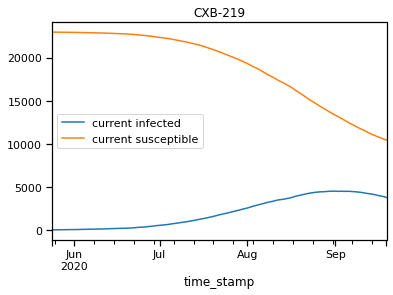

In [49]:
for region in read.regional_summary['region'].unique():
    read.regional_summary[
        read.regional_summary['region'] == region
    ]['current_infected'].plot(label="current infected")
    read.regional_summary[
        read.regional_summary['region'] == region
    ]['current_susceptible'].plot(label="current susceptible")
    plt.title(region)
    plt.legend()
    plt.show()

### Daily infections

In [50]:
summary = read.regional_summary.reset_index()

In [51]:
summary['time_stamp'][0].date()

datetime.date(2020, 5, 24)

In [52]:
def new_infections(summary):
    
    date = []
    for idx, row in summary.iterrows():
        date.append(row['time_stamp'].date())
    summary['date'] = date
    
    dates = np.unique(summary['date'])
    
    new_infections = []
    
    for date in dates:
        date_data = summary['daily_infected'][summary['date'] == date]
        new_infections.append(np.sum(date_data))
        
    return dates, new_infections

In [53]:
dates, new_infections = new_infections(summary)

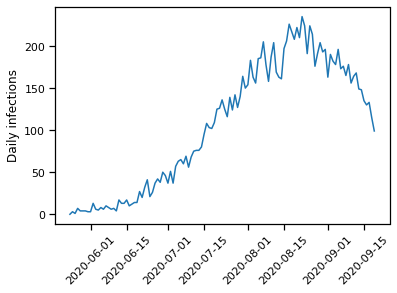

In [54]:
plt.plot(dates, new_infections)
plt.xticks(rotation=45)
plt.ylabel('Daily infections')
plt.show()

### Hospital and intensive care

In [55]:
def hospitalised(summary):
    date = []
    for idx, row in summary.iterrows():
        date.append(row['time_stamp'].date())
    summary['date'] = date
    
    dates = np.unique(summary['date'])
    
    hospitalised = []
    icu = []
    
    for date in dates:
        date_data = summary['current_hospitalised'][summary['date'] == date]
        hospitalised.append(np.sum(date_data))
        date_data = summary['current_intensive_care'][summary['date'] == date]
        icu.append(np.sum(date_data))
        
    return dates, hospitalised, icu

In [56]:
dates, hospitalised, icu = hospitalised(summary)

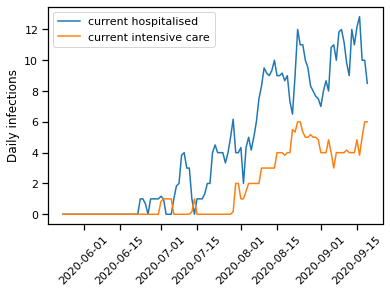

In [57]:
plt.plot(dates, hospitalised, label="current hospitalised")
plt.plot(dates, icu, label="current intensive care")
plt.xticks(rotation=45)
plt.ylabel('Daily infections')
plt.legend()
plt.show()

### Cumulative infections by age

In [72]:
infections_df = read.get_table_with_extras('infections',
                                           'infected_ids')

2021-10-28 11:44:36,694 - june.records.records_reader - INFO - Loading infections table
2021-10-28 11:44:36,705 - june.records.records_reader - INFO - Loading population table
2021-10-28 11:44:36,767 - june.records.records_reader - INFO - Merging infection and population tables
2021-10-28 11:44:36,771 - june.records.records_reader - INFO - Loading geography table
2021-10-28 11:44:36,795 - june.records.records_reader - INFO - Mergeing infection and geography tables


In [73]:
deaths_df = read.get_table_with_extras('deaths', 
                                       'dead_person_ids')

2021-10-28 11:44:37,593 - june.records.records_reader - INFO - Loading deaths table
2021-10-28 11:44:37,600 - june.records.records_reader - INFO - Loading population table
2021-10-28 11:44:37,658 - june.records.records_reader - INFO - Merging infection and population tables
2021-10-28 11:44:37,666 - june.records.records_reader - INFO - Loading geography table
2021-10-28 11:44:37,689 - june.records.records_reader - INFO - Mergeing infection and geography tables


In [74]:
age_bins = (0,20,60,100)

In [75]:
infected_by_age = infections_df.groupby([pd.cut(infections_df['age'],
            bins=age_bins), 'timestamp']).size()

In [76]:
people_df = read.table_to_df('population')

In [77]:
n_by_age = people_df.groupby(pd.cut(people_df['age'],
            bins=age_bins)).size()

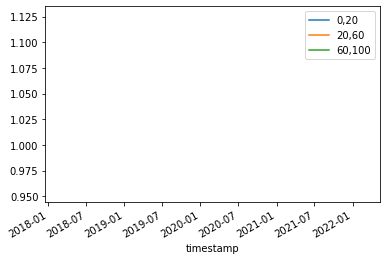

In [78]:
(100*infected_by_age/n_by_age).xs(10).cumsum().plot(label='0,20')
(100*infected_by_age/n_by_age).xs(30).cumsum().plot(label='20,60')
(100*infected_by_age/n_by_age).xs(70).cumsum().plot(label='60,100')
plt.legend()

### Where people get infected

In [79]:
locations_df = infections_df.groupby(['location_specs', 
                                'timestamp']).size()

<AxesSubplot:xlabel='timestamp'>

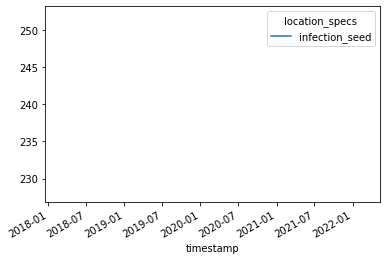

In [80]:
locations_df.unstack(level=0).plot()

Text(0.5, 0, 'location')

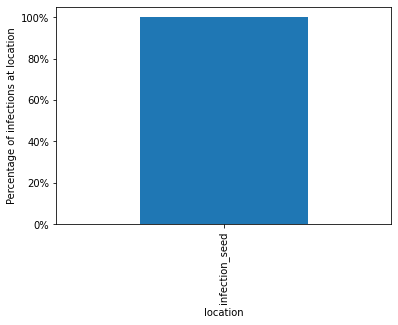

In [81]:
import matplotlib.ticker as mtick
location_counts_df = locations_df.groupby('location_specs').size()
location_counts_df = 100*location_counts_df / location_counts_df.sum()
ax = location_counts_df.sort_values().plot.bar()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Percentage of infections at location')
plt.xlabel('location')